In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Path = "../input/pokemon-images-dataset/pokemon_jpg"

In [3]:
os.listdir(Path)

['pokemon_jpg']

In [4]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(Path,transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats),
    tt.RandomHorizontalFlip(p=0.5)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [7]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

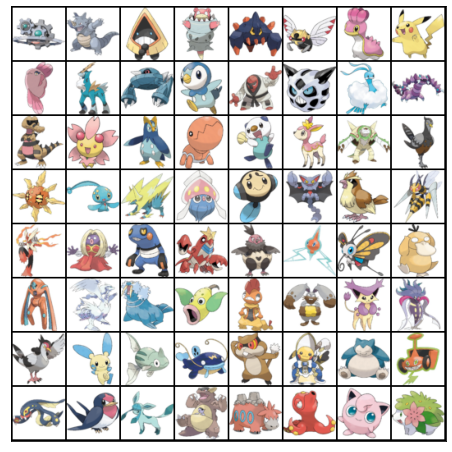

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [13]:
discriminator = to_device(discriminator,device)

In [14]:
latent_size = 128
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias = False),
    nn.Tanh()
)

torch.Size([64, 3, 64, 64])


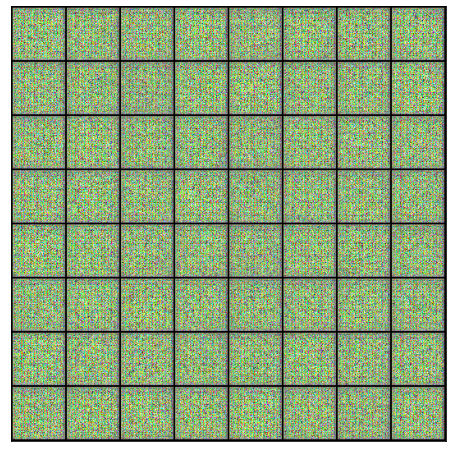

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
generator = to_device(generator,device)

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt):
    opt.zero_grad()
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device = device)
    loss = F.binary_cross_entropy(preds,targets)
    loss.backward()
    opt.step()
    return loss.item()
    

In [19]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


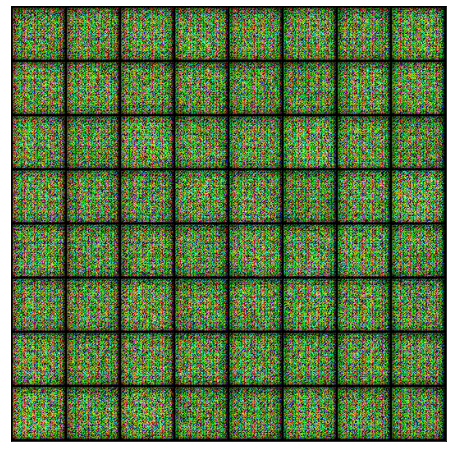

In [22]:
save_samples(0, fixed_latent)

In [23]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [24]:
lr = 0.0002
epochs = 1000
history = fit(epochs, lr)


Epoch [1/1000], loss_g: 11.9068, loss_d: 1.8130, real_score: 0.9713, fake_score: 0.8209
Saving generated-images-0001.png



Epoch [2/1000], loss_g: 14.4857, loss_d: 1.2677, real_score: 0.9718, fake_score: 0.6950
Saving generated-images-0002.png



Epoch [3/1000], loss_g: 7.0706, loss_d: 0.0736, real_score: 0.9833, fake_score: 0.0545
Saving generated-images-0003.png



Epoch [4/1000], loss_g: 11.1205, loss_d: 0.0227, real_score: 0.9781, fake_score: 0.0000
Saving generated-images-0004.png



Epoch [5/1000], loss_g: 8.3197, loss_d: 0.0490, real_score: 0.9929, fake_score: 0.0410
Saving generated-images-0005.png



Epoch [6/1000], loss_g: 6.6354, loss_d: 0.1018, real_score: 0.9281, fake_score: 0.0083
Saving generated-images-0006.png



Epoch [7/1000], loss_g: 16.1398, loss_d: 3.8527, real_score: 0.0607, fake_score: 0.0000
Saving generated-images-0007.png



Epoch [8/1000], loss_g: 3.6208, loss_d: 0.2197, real_score: 0.9267, fake_score: 0.1219
Saving generated-images-0008.png



Epoch [9/1000], loss_g: 2.4289, loss_d: 0.5680, real_score: 0.6651, fake_score: 0.0661
Saving generated-images-0009.png



Epoch [10/1000], loss_g: 1.5972, loss_d: 0.9208, real_score: 0.5068, fake_score: 0.0296
Saving generated-images-0010.png



Epoch [11/1000], loss_g: 1.9188, loss_d: 0.4953, real_score: 0.6941, fake_score: 0.0753
Saving generated-images-0011.png



Epoch [12/1000], loss_g: 3.5724, loss_d: 0.4176, real_score: 0.7493, fake_score: 0.1075
Saving generated-images-0012.png



Epoch [13/1000], loss_g: 4.0695, loss_d: 0.3870, real_score: 0.8448, fake_score: 0.1875
Saving generated-images-0013.png



Epoch [14/1000], loss_g: 3.4202, loss_d: 0.3026, real_score: 0.9112, fake_score: 0.1763
Saving generated-images-0014.png



Epoch [15/1000], loss_g: 3.2755, loss_d: 0.3377, real_score: 0.8691, fake_score: 0.1697
Saving generated-images-0015.png



Epoch [16/1000], loss_g: 2.1889, loss_d: 0.8195, real_score: 0.5316, fake_score: 0.1153
Saving generated-images-0016.png



Epoch [17/1000], loss_g: 4.4842, loss_d: 0.7231, real_score: 0.8231, fake_score: 0.3734
Saving generated-images-0017.png



Epoch [18/1000], loss_g: 1.9975, loss_d: 0.3754, real_score: 0.8116, fake_score: 0.1359
Saving generated-images-0018.png



Epoch [19/1000], loss_g: 2.8760, loss_d: 0.4587, real_score: 0.6813, fake_score: 0.0346
Saving generated-images-0019.png



Epoch [20/1000], loss_g: 3.0521, loss_d: 0.3738, real_score: 0.8177, fake_score: 0.1473
Saving generated-images-0020.png



Epoch [21/1000], loss_g: 3.6910, loss_d: 0.3694, real_score: 0.7221, fake_score: 0.0225
Saving generated-images-0021.png



Epoch [22/1000], loss_g: 3.6450, loss_d: 0.5441, real_score: 0.8812, fake_score: 0.3189
Saving generated-images-0022.png



Epoch [23/1000], loss_g: 2.1598, loss_d: 0.5642, real_score: 0.6274, fake_score: 0.0376
Saving generated-images-0023.png



Epoch [24/1000], loss_g: 2.3508, loss_d: 0.3152, real_score: 0.7956, fake_score: 0.0610
Saving generated-images-0024.png



Epoch [25/1000], loss_g: 3.5640, loss_d: 0.5250, real_score: 0.7824, fake_score: 0.2162
Saving generated-images-0025.png



Epoch [26/1000], loss_g: 2.5556, loss_d: 0.4511, real_score: 0.7625, fake_score: 0.1208
Saving generated-images-0026.png



Epoch [27/1000], loss_g: 7.0476, loss_d: 1.3637, real_score: 0.9671, fake_score: 0.7100
Saving generated-images-0027.png



Epoch [28/1000], loss_g: 2.8175, loss_d: 0.5370, real_score: 0.7803, fake_score: 0.2263
Saving generated-images-0028.png



Epoch [29/1000], loss_g: 1.6054, loss_d: 0.6252, real_score: 0.6373, fake_score: 0.1242
Saving generated-images-0029.png



Epoch [30/1000], loss_g: 3.6134, loss_d: 0.3016, real_score: 0.8653, fake_score: 0.1390
Saving generated-images-0030.png



Epoch [31/1000], loss_g: 2.9792, loss_d: 0.3245, real_score: 0.9625, fake_score: 0.2413
Saving generated-images-0031.png



Epoch [32/1000], loss_g: 3.0866, loss_d: 0.4398, real_score: 0.8049, fake_score: 0.1639
Saving generated-images-0032.png



Epoch [33/1000], loss_g: 2.2730, loss_d: 0.8210, real_score: 0.5560, fake_score: 0.1309
Saving generated-images-0033.png



Epoch [34/1000], loss_g: 3.0110, loss_d: 0.4239, real_score: 0.8585, fake_score: 0.2094
Saving generated-images-0034.png



Epoch [35/1000], loss_g: 2.2529, loss_d: 0.4846, real_score: 0.7933, fake_score: 0.1859
Saving generated-images-0035.png



Epoch [36/1000], loss_g: 6.5335, loss_d: 0.5763, real_score: 0.9273, fake_score: 0.3781
Saving generated-images-0036.png



Epoch [37/1000], loss_g: 2.9471, loss_d: 0.5412, real_score: 0.7675, fake_score: 0.2043
Saving generated-images-0037.png



Epoch [38/1000], loss_g: 2.7104, loss_d: 0.3267, real_score: 0.8911, fake_score: 0.1809
Saving generated-images-0038.png



Epoch [39/1000], loss_g: 1.5429, loss_d: 0.2857, real_score: 0.8303, fake_score: 0.0752
Saving generated-images-0039.png



Epoch [40/1000], loss_g: 2.8802, loss_d: 0.9927, real_score: 0.4145, fake_score: 0.0095
Saving generated-images-0040.png



Epoch [41/1000], loss_g: 2.1929, loss_d: 0.5438, real_score: 0.6906, fake_score: 0.1095
Saving generated-images-0041.png



Epoch [42/1000], loss_g: 8.2740, loss_d: 1.6155, real_score: 0.9700, fake_score: 0.7691
Saving generated-images-0042.png



Epoch [43/1000], loss_g: 2.1889, loss_d: 0.7376, real_score: 0.5306, fake_score: 0.0163
Saving generated-images-0043.png



Epoch [44/1000], loss_g: 2.7654, loss_d: 0.4830, real_score: 0.7600, fake_score: 0.1628
Saving generated-images-0044.png



Epoch [45/1000], loss_g: 3.1955, loss_d: 0.3474, real_score: 0.8226, fake_score: 0.1236
Saving generated-images-0045.png



Epoch [46/1000], loss_g: 3.6275, loss_d: 0.5592, real_score: 0.8564, fake_score: 0.3023
Saving generated-images-0046.png



Epoch [47/1000], loss_g: 2.2384, loss_d: 0.5311, real_score: 0.6405, fake_score: 0.0556
Saving generated-images-0047.png



Epoch [48/1000], loss_g: 5.0851, loss_d: 0.7125, real_score: 0.9793, fake_score: 0.4643
Saving generated-images-0048.png



Epoch [49/1000], loss_g: 3.3650, loss_d: 0.6962, real_score: 0.8259, fake_score: 0.3661
Saving generated-images-0049.png



Epoch [50/1000], loss_g: 1.7895, loss_d: 0.6807, real_score: 0.7027, fake_score: 0.2185
Saving generated-images-0050.png



Epoch [51/1000], loss_g: 3.7003, loss_d: 0.4229, real_score: 0.8744, fake_score: 0.2399
Saving generated-images-0051.png



Epoch [52/1000], loss_g: 2.7648, loss_d: 0.4630, real_score: 0.9342, fake_score: 0.3086
Saving generated-images-0052.png



Epoch [53/1000], loss_g: 0.9807, loss_d: 2.5597, real_score: 0.1112, fake_score: 0.0022
Saving generated-images-0053.png



Epoch [54/1000], loss_g: 2.7398, loss_d: 0.3942, real_score: 0.8353, fake_score: 0.1729
Saving generated-images-0054.png



Epoch [55/1000], loss_g: 2.6801, loss_d: 0.5955, real_score: 0.7678, fake_score: 0.2563
Saving generated-images-0055.png



Epoch [56/1000], loss_g: 7.7666, loss_d: 1.0301, real_score: 0.9375, fake_score: 0.5855
Saving generated-images-0056.png



Epoch [57/1000], loss_g: 3.3943, loss_d: 0.6121, real_score: 0.7482, fake_score: 0.2358
Saving generated-images-0057.png



Epoch [58/1000], loss_g: 1.8908, loss_d: 2.2452, real_score: 0.1403, fake_score: 0.0050
Saving generated-images-0058.png



Epoch [59/1000], loss_g: 1.5621, loss_d: 0.9574, real_score: 0.4483, fake_score: 0.0457
Saving generated-images-0059.png



Epoch [60/1000], loss_g: 2.6772, loss_d: 0.5297, real_score: 0.7471, fake_score: 0.1791
Saving generated-images-0060.png



Epoch [61/1000], loss_g: 4.0210, loss_d: 0.5056, real_score: 0.9431, fake_score: 0.3248
Saving generated-images-0061.png



Epoch [62/1000], loss_g: 5.4761, loss_d: 0.7797, real_score: 0.8827, fake_score: 0.4477
Saving generated-images-0062.png



Epoch [63/1000], loss_g: 2.8457, loss_d: 0.4075, real_score: 0.7665, fake_score: 0.1033
Saving generated-images-0063.png



Epoch [64/1000], loss_g: 6.9430, loss_d: 0.8259, real_score: 0.9391, fake_score: 0.4962
Saving generated-images-0064.png



Epoch [65/1000], loss_g: 3.1304, loss_d: 0.5411, real_score: 0.7598, fake_score: 0.2079
Saving generated-images-0065.png



Epoch [66/1000], loss_g: 2.8138, loss_d: 0.5415, real_score: 0.6506, fake_score: 0.0627
Saving generated-images-0066.png



Epoch [67/1000], loss_g: 4.5766, loss_d: 0.7206, real_score: 0.8907, fake_score: 0.4203
Saving generated-images-0067.png



Epoch [68/1000], loss_g: 3.3606, loss_d: 0.4905, real_score: 0.8110, fake_score: 0.2258
Saving generated-images-0068.png



Epoch [69/1000], loss_g: 3.2376, loss_d: 0.6925, real_score: 0.5453, fake_score: 0.0166
Saving generated-images-0069.png



Epoch [70/1000], loss_g: 2.1409, loss_d: 0.4918, real_score: 0.7707, fake_score: 0.1779
Saving generated-images-0070.png



Epoch [71/1000], loss_g: 0.9915, loss_d: 1.1242, real_score: 0.3890, fake_score: 0.0195
Saving generated-images-0071.png



Epoch [72/1000], loss_g: 2.4782, loss_d: 0.7415, real_score: 0.5548, fake_score: 0.0545
Saving generated-images-0072.png



Epoch [73/1000], loss_g: 3.2892, loss_d: 0.7109, real_score: 0.9638, fake_score: 0.4541
Saving generated-images-0073.png



Epoch [74/1000], loss_g: 6.7242, loss_d: 1.5679, real_score: 0.9890, fake_score: 0.7446
Saving generated-images-0074.png



Epoch [75/1000], loss_g: 4.7363, loss_d: 1.1369, real_score: 0.9487, fake_score: 0.6253
Saving generated-images-0075.png



Epoch [76/1000], loss_g: 4.8713, loss_d: 0.7346, real_score: 0.8989, fake_score: 0.4231
Saving generated-images-0076.png



Epoch [77/1000], loss_g: 1.4208, loss_d: 0.6544, real_score: 0.6359, fake_score: 0.1454
Saving generated-images-0077.png



Epoch [78/1000], loss_g: 2.5587, loss_d: 0.4019, real_score: 0.8264, fake_score: 0.1745
Saving generated-images-0078.png



Epoch [79/1000], loss_g: 1.7442, loss_d: 0.6794, real_score: 0.5838, fake_score: 0.0532
Saving generated-images-0079.png



Epoch [80/1000], loss_g: 1.5918, loss_d: 0.6784, real_score: 0.5610, fake_score: 0.0418
Saving generated-images-0080.png



Epoch [81/1000], loss_g: 4.6429, loss_d: 0.6078, real_score: 0.9090, fake_score: 0.3648
Saving generated-images-0081.png



Epoch [82/1000], loss_g: 0.7609, loss_d: 0.6528, real_score: 0.5896, fake_score: 0.0619
Saving generated-images-0082.png



Epoch [83/1000], loss_g: 3.0647, loss_d: 0.7183, real_score: 0.8474, fake_score: 0.3831
Saving generated-images-0083.png



Epoch [84/1000], loss_g: 2.2830, loss_d: 0.5414, real_score: 0.7346, fake_score: 0.1703
Saving generated-images-0084.png



Epoch [85/1000], loss_g: 2.8295, loss_d: 0.8230, real_score: 0.5100, fake_score: 0.0209
Saving generated-images-0085.png



Epoch [86/1000], loss_g: 1.7302, loss_d: 2.6045, real_score: 0.1016, fake_score: 0.0025
Saving generated-images-0086.png



Epoch [87/1000], loss_g: 3.3657, loss_d: 0.5273, real_score: 0.9157, fake_score: 0.3223
Saving generated-images-0087.png



Epoch [88/1000], loss_g: 2.9977, loss_d: 0.3748, real_score: 0.8287, fake_score: 0.1532
Saving generated-images-0088.png



Epoch [89/1000], loss_g: 2.9812, loss_d: 0.4752, real_score: 0.8292, fake_score: 0.2247
Saving generated-images-0089.png



Epoch [90/1000], loss_g: 2.6495, loss_d: 0.3801, real_score: 0.8569, fake_score: 0.1747
Saving generated-images-0090.png



Epoch [91/1000], loss_g: 2.4251, loss_d: 0.4380, real_score: 0.7443, fake_score: 0.0903
Saving generated-images-0091.png



Epoch [92/1000], loss_g: 3.7486, loss_d: 0.9674, real_score: 0.9841, fake_score: 0.5487
Saving generated-images-0092.png



Epoch [93/1000], loss_g: 2.2618, loss_d: 0.5310, real_score: 0.7040, fake_score: 0.1335
Saving generated-images-0093.png



Epoch [94/1000], loss_g: 2.6324, loss_d: 1.3805, real_score: 0.3192, fake_score: 0.0042
Saving generated-images-0094.png



Epoch [95/1000], loss_g: 2.9808, loss_d: 0.3845, real_score: 0.8548, fake_score: 0.1858
Saving generated-images-0095.png



Epoch [96/1000], loss_g: 2.7564, loss_d: 0.3341, real_score: 0.8344, fake_score: 0.1167
Saving generated-images-0096.png



Epoch [97/1000], loss_g: 3.1712, loss_d: 0.4409, real_score: 0.8251, fake_score: 0.1876
Saving generated-images-0097.png



Epoch [98/1000], loss_g: 1.9433, loss_d: 0.6076, real_score: 0.5989, fake_score: 0.0434
Saving generated-images-0098.png



Epoch [99/1000], loss_g: 4.1894, loss_d: 0.5419, real_score: 0.9092, fake_score: 0.3289
Saving generated-images-0099.png



Epoch [100/1000], loss_g: 5.2361, loss_d: 0.5643, real_score: 0.9290, fake_score: 0.3598
Saving generated-images-0100.png



Epoch [101/1000], loss_g: 2.8506, loss_d: 0.3621, real_score: 0.9383, fake_score: 0.2289
Saving generated-images-0101.png



Epoch [102/1000], loss_g: 2.0472, loss_d: 0.7149, real_score: 0.5572, fake_score: 0.0447
Saving generated-images-0102.png



Epoch [103/1000], loss_g: 3.2419, loss_d: 0.4277, real_score: 0.9199, fake_score: 0.2495
Saving generated-images-0103.png



Epoch [104/1000], loss_g: 4.5998, loss_d: 0.6711, real_score: 0.9230, fake_score: 0.4078
Saving generated-images-0104.png



Epoch [105/1000], loss_g: 6.5590, loss_d: 0.6016, real_score: 0.9428, fake_score: 0.3813
Saving generated-images-0105.png



Epoch [106/1000], loss_g: 2.7773, loss_d: 0.4456, real_score: 0.7278, fake_score: 0.0874
Saving generated-images-0106.png



Epoch [107/1000], loss_g: 3.7478, loss_d: 0.4955, real_score: 0.8875, fake_score: 0.2745
Saving generated-images-0107.png



Epoch [108/1000], loss_g: 2.8215, loss_d: 0.3203, real_score: 0.8014, fake_score: 0.0753
Saving generated-images-0108.png



Epoch [109/1000], loss_g: 2.4719, loss_d: 0.4297, real_score: 0.8023, fake_score: 0.1547
Saving generated-images-0109.png



Epoch [110/1000], loss_g: 3.9227, loss_d: 0.5027, real_score: 0.9118, fake_score: 0.3020
Saving generated-images-0110.png



Epoch [111/1000], loss_g: 3.7859, loss_d: 0.3578, real_score: 0.8117, fake_score: 0.1112
Saving generated-images-0111.png



Epoch [112/1000], loss_g: 2.0046, loss_d: 0.6574, real_score: 0.5843, fake_score: 0.0360
Saving generated-images-0112.png



Epoch [113/1000], loss_g: 2.6444, loss_d: 0.4090, real_score: 0.7490, fake_score: 0.0741
Saving generated-images-0113.png



Epoch [114/1000], loss_g: 2.1298, loss_d: 2.7388, real_score: 0.1265, fake_score: 0.0018
Saving generated-images-0114.png



Epoch [115/1000], loss_g: 3.4259, loss_d: 0.3522, real_score: 0.8450, fake_score: 0.1418
Saving generated-images-0115.png



Epoch [116/1000], loss_g: 3.7720, loss_d: 0.2776, real_score: 0.8487, fake_score: 0.0871
Saving generated-images-0116.png



Epoch [117/1000], loss_g: 5.9640, loss_d: 0.9507, real_score: 0.9710, fake_score: 0.5296
Saving generated-images-0117.png



Epoch [118/1000], loss_g: 4.1756, loss_d: 0.5791, real_score: 0.9611, fake_score: 0.3623
Saving generated-images-0118.png



Epoch [119/1000], loss_g: 2.7480, loss_d: 0.4431, real_score: 0.7215, fake_score: 0.0539
Saving generated-images-0119.png



Epoch [120/1000], loss_g: 3.1947, loss_d: 0.4201, real_score: 0.7452, fake_score: 0.0863
Saving generated-images-0120.png



Epoch [121/1000], loss_g: 3.5696, loss_d: 0.4196, real_score: 0.8853, fake_score: 0.2228
Saving generated-images-0121.png



Epoch [122/1000], loss_g: 1.9551, loss_d: 0.5131, real_score: 0.6681, fake_score: 0.0508
Saving generated-images-0122.png



Epoch [123/1000], loss_g: 5.4985, loss_d: 0.5455, real_score: 0.9351, fake_score: 0.3346
Saving generated-images-0123.png



Epoch [124/1000], loss_g: 2.6365, loss_d: 0.2921, real_score: 0.8362, fake_score: 0.0892
Saving generated-images-0124.png



Epoch [125/1000], loss_g: 3.8717, loss_d: 0.3923, real_score: 0.8935, fake_score: 0.2149
Saving generated-images-0125.png



Epoch [126/1000], loss_g: 2.8231, loss_d: 0.3374, real_score: 0.7817, fake_score: 0.0568
Saving generated-images-0126.png



Epoch [127/1000], loss_g: 3.6876, loss_d: 0.4602, real_score: 0.6834, fake_score: 0.0173
Saving generated-images-0127.png



Epoch [128/1000], loss_g: 3.5280, loss_d: 0.2541, real_score: 0.8625, fake_score: 0.0839
Saving generated-images-0128.png



Epoch [129/1000], loss_g: 4.2977, loss_d: 0.2249, real_score: 0.8944, fake_score: 0.0926
Saving generated-images-0129.png



Epoch [130/1000], loss_g: 4.8986, loss_d: 0.3287, real_score: 0.9527, fake_score: 0.2172
Saving generated-images-0130.png



Epoch [131/1000], loss_g: 0.6749, loss_d: 0.7614, real_score: 0.5360, fake_score: 0.0138
Saving generated-images-0131.png



Epoch [132/1000], loss_g: 3.9221, loss_d: 0.6441, real_score: 0.8960, fake_score: 0.3329
Saving generated-images-0132.png



Epoch [133/1000], loss_g: 3.1213, loss_d: 0.3075, real_score: 0.8805, fake_score: 0.1461
Saving generated-images-0133.png



Epoch [134/1000], loss_g: 2.9932, loss_d: 0.8643, real_score: 0.4768, fake_score: 0.0085
Saving generated-images-0134.png



Epoch [135/1000], loss_g: 3.7790, loss_d: 0.3920, real_score: 0.7760, fake_score: 0.0481
Saving generated-images-0135.png



Epoch [136/1000], loss_g: 2.0643, loss_d: 0.4123, real_score: 0.7695, fake_score: 0.0906
Saving generated-images-0136.png



Epoch [137/1000], loss_g: 3.1509, loss_d: 0.4409, real_score: 0.8467, fake_score: 0.1924
Saving generated-images-0137.png



Epoch [138/1000], loss_g: 2.9150, loss_d: 0.3721, real_score: 0.8189, fake_score: 0.1273
Saving generated-images-0138.png



Epoch [139/1000], loss_g: 3.3313, loss_d: 0.3609, real_score: 0.7730, fake_score: 0.0614
Saving generated-images-0139.png



Epoch [140/1000], loss_g: 1.5147, loss_d: 0.5522, real_score: 0.6334, fake_score: 0.0327
Saving generated-images-0140.png



Epoch [141/1000], loss_g: 5.0395, loss_d: 0.3487, real_score: 0.9495, fake_score: 0.2238
Saving generated-images-0141.png



Epoch [142/1000], loss_g: 3.9551, loss_d: 0.4096, real_score: 0.7101, fake_score: 0.0144
Saving generated-images-0142.png



Epoch [143/1000], loss_g: 1.5485, loss_d: 0.5011, real_score: 0.6906, fake_score: 0.0482
Saving generated-images-0143.png



Epoch [144/1000], loss_g: 3.8774, loss_d: 0.3173, real_score: 0.8762, fake_score: 0.1422
Saving generated-images-0144.png



Epoch [145/1000], loss_g: 2.6535, loss_d: 0.1499, real_score: 0.9258, fake_score: 0.0607
Saving generated-images-0145.png



Epoch [146/1000], loss_g: 2.5924, loss_d: 0.3210, real_score: 0.8102, fake_score: 0.0759
Saving generated-images-0146.png



Epoch [147/1000], loss_g: 5.6851, loss_d: 0.4054, real_score: 0.9492, fake_score: 0.2619
Saving generated-images-0147.png



Epoch [148/1000], loss_g: 5.5622, loss_d: 0.3758, real_score: 0.9641, fake_score: 0.2599
Saving generated-images-0148.png



Epoch [149/1000], loss_g: 3.1177, loss_d: 1.2255, real_score: 0.3498, fake_score: 0.0027
Saving generated-images-0149.png



Epoch [150/1000], loss_g: 7.1759, loss_d: 1.0028, real_score: 0.9748, fake_score: 0.5412
Saving generated-images-0150.png



Epoch [151/1000], loss_g: 2.8993, loss_d: 0.3718, real_score: 0.8402, fake_score: 0.1357
Saving generated-images-0151.png



Epoch [152/1000], loss_g: 4.0157, loss_d: 0.2334, real_score: 0.8778, fake_score: 0.0750
Saving generated-images-0152.png



Epoch [153/1000], loss_g: 5.4396, loss_d: 0.2129, real_score: 0.9436, fake_score: 0.1295
Saving generated-images-0153.png



Epoch [154/1000], loss_g: 3.7418, loss_d: 0.2291, real_score: 0.8772, fake_score: 0.0636
Saving generated-images-0154.png



Epoch [155/1000], loss_g: 5.2059, loss_d: 0.2891, real_score: 0.9715, fake_score: 0.2006
Saving generated-images-0155.png



Epoch [156/1000], loss_g: 3.7931, loss_d: 0.2158, real_score: 0.9179, fake_score: 0.1050
Saving generated-images-0156.png



Epoch [157/1000], loss_g: 4.3803, loss_d: 0.5425, real_score: 0.9572, fake_score: 0.3115
Saving generated-images-0157.png



Epoch [158/1000], loss_g: 3.8545, loss_d: 0.2683, real_score: 0.8950, fake_score: 0.1246
Saving generated-images-0158.png



Epoch [159/1000], loss_g: 3.2977, loss_d: 0.2074, real_score: 0.8883, fake_score: 0.0742
Saving generated-images-0159.png



Epoch [160/1000], loss_g: 5.4143, loss_d: 0.8472, real_score: 0.8769, fake_score: 0.4111
Saving generated-images-0160.png



Epoch [161/1000], loss_g: 3.6697, loss_d: 0.5054, real_score: 0.8815, fake_score: 0.2596
Saving generated-images-0161.png



Epoch [162/1000], loss_g: 3.5250, loss_d: 0.2232, real_score: 0.8834, fake_score: 0.0783
Saving generated-images-0162.png



Epoch [163/1000], loss_g: 2.3316, loss_d: 0.2333, real_score: 0.8639, fake_score: 0.0653
Saving generated-images-0163.png



Epoch [164/1000], loss_g: 3.7052, loss_d: 0.2206, real_score: 0.8729, fake_score: 0.0661
Saving generated-images-0164.png



Epoch [165/1000], loss_g: 3.9627, loss_d: 0.1415, real_score: 0.9487, fake_score: 0.0787
Saving generated-images-0165.png



Epoch [166/1000], loss_g: 5.0949, loss_d: 0.1924, real_score: 0.9736, fake_score: 0.1403
Saving generated-images-0166.png



Epoch [167/1000], loss_g: 3.3112, loss_d: 0.1378, real_score: 0.9426, fake_score: 0.0700
Saving generated-images-0167.png



Epoch [168/1000], loss_g: 4.3582, loss_d: 0.1123, real_score: 0.9300, fake_score: 0.0340
Saving generated-images-0168.png



Epoch [169/1000], loss_g: 8.1812, loss_d: 1.0624, real_score: 0.9939, fake_score: 0.5438
Saving generated-images-0169.png



Epoch [170/1000], loss_g: 4.7370, loss_d: 0.2091, real_score: 0.9184, fake_score: 0.1021
Saving generated-images-0170.png



Epoch [171/1000], loss_g: 4.3475, loss_d: 0.1601, real_score: 0.9101, fake_score: 0.0569
Saving generated-images-0171.png



Epoch [172/1000], loss_g: 3.0942, loss_d: 0.2065, real_score: 0.8542, fake_score: 0.0264
Saving generated-images-0172.png



Epoch [173/1000], loss_g: 3.2743, loss_d: 0.1844, real_score: 0.9013, fake_score: 0.0672
Saving generated-images-0173.png



Epoch [174/1000], loss_g: 6.3892, loss_d: 0.8020, real_score: 0.9614, fake_score: 0.4492
Saving generated-images-0174.png



Epoch [175/1000], loss_g: 2.3228, loss_d: 0.4339, real_score: 0.7720, fake_score: 0.0959
Saving generated-images-0175.png



Epoch [176/1000], loss_g: 1.5294, loss_d: 0.5142, real_score: 0.6939, fake_score: 0.0291
Saving generated-images-0176.png



Epoch [177/1000], loss_g: 5.0795, loss_d: 0.1872, real_score: 0.8918, fake_score: 0.0510
Saving generated-images-0177.png



Epoch [178/1000], loss_g: 3.9040, loss_d: 0.2076, real_score: 0.9100, fake_score: 0.0897
Saving generated-images-0178.png



Epoch [179/1000], loss_g: 4.7073, loss_d: 0.2189, real_score: 0.9613, fake_score: 0.1467
Saving generated-images-0179.png



Epoch [180/1000], loss_g: 3.9166, loss_d: 0.1947, real_score: 0.9396, fake_score: 0.1112
Saving generated-images-0180.png



Epoch [181/1000], loss_g: 5.4548, loss_d: 0.2193, real_score: 0.9678, fake_score: 0.1507
Saving generated-images-0181.png



Epoch [182/1000], loss_g: 2.3204, loss_d: 0.5492, real_score: 0.6308, fake_score: 0.0030
Saving generated-images-0182.png



Epoch [183/1000], loss_g: 3.6257, loss_d: 0.1255, real_score: 0.9606, fake_score: 0.0758
Saving generated-images-0183.png



Epoch [184/1000], loss_g: 4.6940, loss_d: 0.1749, real_score: 0.9440, fake_score: 0.0944
Saving generated-images-0184.png



Epoch [185/1000], loss_g: 4.5116, loss_d: 0.1289, real_score: 0.9466, fake_score: 0.0658
Saving generated-images-0185.png



Epoch [186/1000], loss_g: 5.6604, loss_d: 0.2018, real_score: 0.9718, fake_score: 0.1350
Saving generated-images-0186.png



Epoch [187/1000], loss_g: 4.1479, loss_d: 0.1214, real_score: 0.9433, fake_score: 0.0548
Saving generated-images-0187.png



Epoch [188/1000], loss_g: 4.8686, loss_d: 0.0932, real_score: 0.9889, fake_score: 0.0760
Saving generated-images-0188.png



Epoch [189/1000], loss_g: 4.7196, loss_d: 0.0885, real_score: 0.9652, fake_score: 0.0488
Saving generated-images-0189.png



Epoch [190/1000], loss_g: 0.4374, loss_d: 1.0123, real_score: 0.6657, fake_score: 0.2766
Saving generated-images-0190.png



Epoch [191/1000], loss_g: 3.9700, loss_d: 0.9269, real_score: 0.9179, fake_score: 0.4629
Saving generated-images-0191.png



Epoch [192/1000], loss_g: 5.9871, loss_d: 0.6655, real_score: 0.8904, fake_score: 0.3187
Saving generated-images-0192.png



Epoch [193/1000], loss_g: 4.6549, loss_d: 0.2405, real_score: 0.9376, fake_score: 0.1244
Saving generated-images-0193.png



Epoch [194/1000], loss_g: 3.3522, loss_d: 0.2918, real_score: 0.8331, fake_score: 0.0628
Saving generated-images-0194.png



Epoch [195/1000], loss_g: 3.7865, loss_d: 0.2214, real_score: 0.8994, fake_score: 0.0956
Saving generated-images-0195.png



Epoch [196/1000], loss_g: 4.8825, loss_d: 0.2590, real_score: 0.9500, fake_score: 0.1642
Saving generated-images-0196.png



Epoch [197/1000], loss_g: 4.0511, loss_d: 0.1490, real_score: 0.9023, fake_score: 0.0346
Saving generated-images-0197.png



Epoch [198/1000], loss_g: 4.0967, loss_d: 0.1195, real_score: 0.9561, fake_score: 0.0622
Saving generated-images-0198.png



Epoch [199/1000], loss_g: 3.1919, loss_d: 0.2151, real_score: 0.8475, fake_score: 0.0303
Saving generated-images-0199.png



Epoch [200/1000], loss_g: 5.8909, loss_d: 0.2043, real_score: 0.9805, fake_score: 0.1524
Saving generated-images-0200.png



Epoch [201/1000], loss_g: 3.5507, loss_d: 0.1716, real_score: 0.8899, fake_score: 0.0435
Saving generated-images-0201.png



Epoch [202/1000], loss_g: 4.5570, loss_d: 0.0772, real_score: 0.9590, fake_score: 0.0332
Saving generated-images-0202.png



Epoch [203/1000], loss_g: 4.0197, loss_d: 0.1499, real_score: 0.8848, fake_score: 0.0196
Saving generated-images-0203.png



Epoch [204/1000], loss_g: 7.7720, loss_d: 0.2507, real_score: 0.9844, fake_score: 0.1905
Saving generated-images-0204.png



Epoch [205/1000], loss_g: 4.2291, loss_d: 0.1954, real_score: 0.8771, fake_score: 0.0198
Saving generated-images-0205.png



Epoch [206/1000], loss_g: 3.1305, loss_d: 1.1051, real_score: 0.5004, fake_score: 0.0628
Saving generated-images-0206.png



Epoch [207/1000], loss_g: 4.8727, loss_d: 0.3883, real_score: 0.9249, fake_score: 0.2022
Saving generated-images-0207.png



Epoch [208/1000], loss_g: 4.1024, loss_d: 0.1675, real_score: 0.9234, fake_score: 0.0698
Saving generated-images-0208.png



Epoch [209/1000], loss_g: 4.9375, loss_d: 0.1844, real_score: 0.8723, fake_score: 0.0244
Saving generated-images-0209.png



Epoch [210/1000], loss_g: 3.8068, loss_d: 0.1529, real_score: 0.9515, fake_score: 0.0818
Saving generated-images-0210.png



Epoch [211/1000], loss_g: 4.6701, loss_d: 0.1190, real_score: 0.9581, fake_score: 0.0674
Saving generated-images-0211.png



Epoch [212/1000], loss_g: 5.2893, loss_d: 0.1873, real_score: 0.9721, fake_score: 0.1250
Saving generated-images-0212.png



Epoch [213/1000], loss_g: 4.0681, loss_d: 0.0993, real_score: 0.9455, fake_score: 0.0356
Saving generated-images-0213.png



Epoch [214/1000], loss_g: 4.9301, loss_d: 0.1520, real_score: 0.9541, fake_score: 0.0805
Saving generated-images-0214.png



Epoch [215/1000], loss_g: 5.0838, loss_d: 0.0596, real_score: 0.9594, fake_score: 0.0160
Saving generated-images-0215.png



Epoch [216/1000], loss_g: 4.9957, loss_d: 0.1195, real_score: 0.9764, fake_score: 0.0821
Saving generated-images-0216.png



Epoch [217/1000], loss_g: 4.6895, loss_d: 0.0916, real_score: 0.9591, fake_score: 0.0440
Saving generated-images-0217.png



Epoch [218/1000], loss_g: 5.3464, loss_d: 0.0682, real_score: 0.9657, fake_score: 0.0299
Saving generated-images-0218.png



Epoch [219/1000], loss_g: 4.1545, loss_d: 0.0729, real_score: 0.9678, fake_score: 0.0373
Saving generated-images-0219.png



Epoch [220/1000], loss_g: 5.3001, loss_d: 0.0870, real_score: 0.9641, fake_score: 0.0439
Saving generated-images-0220.png



Epoch [221/1000], loss_g: 4.0513, loss_d: 0.6022, real_score: 0.5911, fake_score: 0.0006
Saving generated-images-0221.png



Epoch [222/1000], loss_g: 7.2285, loss_d: 0.4521, real_score: 0.9928, fake_score: 0.2789
Saving generated-images-0222.png



Epoch [223/1000], loss_g: 4.4063, loss_d: 0.1401, real_score: 0.9326, fake_score: 0.0552
Saving generated-images-0223.png



Epoch [224/1000], loss_g: 4.0275, loss_d: 0.1046, real_score: 0.9373, fake_score: 0.0335
Saving generated-images-0224.png



Epoch [225/1000], loss_g: 4.9096, loss_d: 0.0776, real_score: 0.9661, fake_score: 0.0399
Saving generated-images-0225.png



Epoch [226/1000], loss_g: 4.0164, loss_d: 0.0521, real_score: 0.9646, fake_score: 0.0147
Saving generated-images-0226.png



Epoch [227/1000], loss_g: 3.7912, loss_d: 0.0628, real_score: 0.9632, fake_score: 0.0220
Saving generated-images-0227.png



Epoch [228/1000], loss_g: 4.4476, loss_d: 0.0729, real_score: 0.9520, fake_score: 0.0202
Saving generated-images-0228.png



Epoch [229/1000], loss_g: 6.4723, loss_d: 0.0485, real_score: 0.9636, fake_score: 0.0105
Saving generated-images-0229.png



Epoch [230/1000], loss_g: 5.3723, loss_d: 0.0943, real_score: 0.9645, fake_score: 0.0517
Saving generated-images-0230.png



Epoch [231/1000], loss_g: 4.7415, loss_d: 0.0480, real_score: 0.9769, fake_score: 0.0235
Saving generated-images-0231.png



Epoch [232/1000], loss_g: 5.8376, loss_d: 0.0803, real_score: 0.9818, fake_score: 0.0516
Saving generated-images-0232.png



Epoch [233/1000], loss_g: 5.2634, loss_d: 0.0673, real_score: 0.9742, fake_score: 0.0368
Saving generated-images-0233.png



Epoch [234/1000], loss_g: 4.7125, loss_d: 0.0630, real_score: 0.9709, fake_score: 0.0318
Saving generated-images-0234.png



Epoch [235/1000], loss_g: 5.1007, loss_d: 0.0470, real_score: 0.9698, fake_score: 0.0153
Saving generated-images-0235.png



Epoch [236/1000], loss_g: 5.0272, loss_d: 0.0802, real_score: 0.9397, fake_score: 0.0150
Saving generated-images-0236.png



Epoch [237/1000], loss_g: 4.4387, loss_d: 0.0946, real_score: 0.9479, fake_score: 0.0338
Saving generated-images-0237.png



Epoch [238/1000], loss_g: 5.1588, loss_d: 0.0859, real_score: 0.9495, fake_score: 0.0297
Saving generated-images-0238.png



Epoch [239/1000], loss_g: 5.8325, loss_d: 0.0459, real_score: 0.9644, fake_score: 0.0072
Saving generated-images-0239.png



Epoch [240/1000], loss_g: 2.2900, loss_d: 7.3471, real_score: 0.0015, fake_score: 0.0000
Saving generated-images-0240.png



Epoch [241/1000], loss_g: 4.9534, loss_d: 0.5850, real_score: 0.6635, fake_score: 0.0211
Saving generated-images-0241.png



Epoch [242/1000], loss_g: 5.9889, loss_d: 0.1687, real_score: 0.9119, fake_score: 0.0494
Saving generated-images-0242.png



Epoch [243/1000], loss_g: 6.3127, loss_d: 0.7610, real_score: 0.9098, fake_score: 0.3350
Saving generated-images-0243.png



Epoch [244/1000], loss_g: 5.7005, loss_d: 0.2989, real_score: 0.9337, fake_score: 0.1685
Saving generated-images-0244.png



Epoch [245/1000], loss_g: 5.0590, loss_d: 0.2001, real_score: 0.9147, fake_score: 0.0654
Saving generated-images-0245.png



Epoch [246/1000], loss_g: 4.6669, loss_d: 0.1553, real_score: 0.9165, fake_score: 0.0454
Saving generated-images-0246.png



Epoch [247/1000], loss_g: 4.0791, loss_d: 0.1704, real_score: 0.9004, fake_score: 0.0507
Saving generated-images-0247.png



Epoch [248/1000], loss_g: 6.0822, loss_d: 0.1991, real_score: 0.9790, fake_score: 0.1400
Saving generated-images-0248.png



Epoch [249/1000], loss_g: 4.4329, loss_d: 0.0951, real_score: 0.9593, fake_score: 0.0483
Saving generated-images-0249.png



Epoch [250/1000], loss_g: 4.9566, loss_d: 0.1191, real_score: 0.9689, fake_score: 0.0727
Saving generated-images-0250.png



Epoch [251/1000], loss_g: 4.9036, loss_d: 0.0667, real_score: 0.9844, fake_score: 0.0442
Saving generated-images-0251.png



Epoch [252/1000], loss_g: 4.1992, loss_d: 0.0915, real_score: 0.9613, fake_score: 0.0465
Saving generated-images-0252.png



Epoch [253/1000], loss_g: 5.2876, loss_d: 0.0421, real_score: 0.9778, fake_score: 0.0187
Saving generated-images-0253.png



Epoch [254/1000], loss_g: 4.9549, loss_d: 0.0877, real_score: 0.9700, fake_score: 0.0507
Saving generated-images-0254.png



Epoch [255/1000], loss_g: 3.8411, loss_d: 0.1196, real_score: 0.9014, fake_score: 0.0077
Saving generated-images-0255.png



Epoch [256/1000], loss_g: 4.1511, loss_d: 0.0678, real_score: 0.9537, fake_score: 0.0185
Saving generated-images-0256.png



Epoch [257/1000], loss_g: 4.7173, loss_d: 0.0603, real_score: 0.9731, fake_score: 0.0297
Saving generated-images-0257.png



Epoch [258/1000], loss_g: 5.8080, loss_d: 0.0976, real_score: 0.9890, fake_score: 0.0770
Saving generated-images-0258.png



Epoch [259/1000], loss_g: 6.1542, loss_d: 0.0426, real_score: 0.9782, fake_score: 0.0189
Saving generated-images-0259.png



Epoch [260/1000], loss_g: 5.2101, loss_d: 0.0364, real_score: 0.9778, fake_score: 0.0136
Saving generated-images-0260.png



Epoch [261/1000], loss_g: 3.6326, loss_d: 0.0655, real_score: 0.9542, fake_score: 0.0167
Saving generated-images-0261.png



Epoch [262/1000], loss_g: 5.0600, loss_d: 0.0384, real_score: 0.9824, fake_score: 0.0198
Saving generated-images-0262.png



Epoch [263/1000], loss_g: 5.9934, loss_d: 0.0467, real_score: 0.9673, fake_score: 0.0123
Saving generated-images-0263.png



Epoch [264/1000], loss_g: 5.3180, loss_d: 0.0482, real_score: 0.9738, fake_score: 0.0205
Saving generated-images-0264.png



Epoch [265/1000], loss_g: 5.7244, loss_d: 0.0432, real_score: 0.9803, fake_score: 0.0215
Saving generated-images-0265.png



Epoch [266/1000], loss_g: 5.3580, loss_d: 0.0404, real_score: 0.9801, fake_score: 0.0187
Saving generated-images-0266.png



Epoch [267/1000], loss_g: 5.3755, loss_d: 0.0349, real_score: 0.9838, fake_score: 0.0179
Saving generated-images-0267.png



Epoch [268/1000], loss_g: 5.4563, loss_d: 0.0482, real_score: 0.9700, fake_score: 0.0165
Saving generated-images-0268.png



Epoch [269/1000], loss_g: 5.5350, loss_d: 0.0379, real_score: 0.9863, fake_score: 0.0227
Saving generated-images-0269.png



Epoch [270/1000], loss_g: 5.2734, loss_d: 0.0449, real_score: 0.9877, fake_score: 0.0303
Saving generated-images-0270.png



Epoch [271/1000], loss_g: 5.4853, loss_d: 0.0227, real_score: 0.9865, fake_score: 0.0089
Saving generated-images-0271.png



Epoch [272/1000], loss_g: 5.4976, loss_d: 0.0237, real_score: 0.9927, fake_score: 0.0160
Saving generated-images-0272.png



Epoch [273/1000], loss_g: 5.6918, loss_d: 0.0332, real_score: 0.9908, fake_score: 0.0228
Saving generated-images-0273.png



Epoch [274/1000], loss_g: 5.0431, loss_d: 0.0456, real_score: 0.9741, fake_score: 0.0181
Saving generated-images-0274.png



Epoch [275/1000], loss_g: 4.1845, loss_d: 0.1909, real_score: 0.8393, fake_score: 0.0008
Saving generated-images-0275.png



Epoch [276/1000], loss_g: 6.9636, loss_d: 0.0743, real_score: 0.9916, fake_score: 0.0592
Saving generated-images-0276.png



Epoch [277/1000], loss_g: 5.3497, loss_d: 0.0424, real_score: 0.9919, fake_score: 0.0314
Saving generated-images-0277.png



Epoch [278/1000], loss_g: 6.3217, loss_d: 0.0291, real_score: 0.9893, fake_score: 0.0178
Saving generated-images-0278.png



Epoch [279/1000], loss_g: 5.6973, loss_d: 0.0570, real_score: 0.9744, fake_score: 0.0283
Saving generated-images-0279.png



Epoch [280/1000], loss_g: 5.6504, loss_d: 0.0332, real_score: 0.9803, fake_score: 0.0129
Saving generated-images-0280.png



Epoch [281/1000], loss_g: 4.8834, loss_d: 0.0393, real_score: 0.9771, fake_score: 0.0151
Saving generated-images-0281.png



Epoch [282/1000], loss_g: 5.3363, loss_d: 0.0241, real_score: 0.9921, fake_score: 0.0157
Saving generated-images-0282.png



Epoch [283/1000], loss_g: 5.0070, loss_d: 0.0363, real_score: 0.9882, fake_score: 0.0235
Saving generated-images-0283.png



Epoch [284/1000], loss_g: 6.5139, loss_d: 0.0269, real_score: 0.9912, fake_score: 0.0173
Saving generated-images-0284.png



Epoch [285/1000], loss_g: 5.1069, loss_d: 0.0319, real_score: 0.9835, fake_score: 0.0144
Saving generated-images-0285.png



Epoch [286/1000], loss_g: 1.6236, loss_d: 7.1825, real_score: 0.9906, fake_score: 0.9486
Saving generated-images-0286.png



Epoch [287/1000], loss_g: 1.4632, loss_d: 1.1202, real_score: 0.7033, fake_score: 0.3990
Saving generated-images-0287.png



Epoch [288/1000], loss_g: 2.3618, loss_d: 0.8886, real_score: 0.5915, fake_score: 0.1130
Saving generated-images-0288.png



Epoch [289/1000], loss_g: 2.4526, loss_d: 1.4773, real_score: 0.3608, fake_score: 0.0419
Saving generated-images-0289.png



Epoch [290/1000], loss_g: 2.2947, loss_d: 0.6130, real_score: 0.7581, fake_score: 0.1797
Saving generated-images-0290.png



Epoch [291/1000], loss_g: 3.1718, loss_d: 0.7619, real_score: 0.5889, fake_score: 0.0384
Saving generated-images-0291.png



Epoch [292/1000], loss_g: 4.8971, loss_d: 0.4040, real_score: 0.8113, fake_score: 0.0985
Saving generated-images-0292.png



Epoch [293/1000], loss_g: 5.9059, loss_d: 0.7230, real_score: 0.8813, fake_score: 0.3482
Saving generated-images-0293.png



Epoch [294/1000], loss_g: 4.5889, loss_d: 0.3286, real_score: 0.8642, fake_score: 0.0925
Saving generated-images-0294.png



Epoch [295/1000], loss_g: 5.0325, loss_d: 0.3441, real_score: 0.8815, fake_score: 0.1439
Saving generated-images-0295.png



Epoch [296/1000], loss_g: 5.1186, loss_d: 0.1579, real_score: 0.9142, fake_score: 0.0550
Saving generated-images-0296.png



Epoch [297/1000], loss_g: 5.5241, loss_d: 0.2423, real_score: 0.9235, fake_score: 0.1267
Saving generated-images-0297.png



Epoch [298/1000], loss_g: 6.8748, loss_d: 0.2380, real_score: 0.9451, fake_score: 0.1224
Saving generated-images-0298.png



Epoch [299/1000], loss_g: 4.9317, loss_d: 0.1811, real_score: 0.9320, fake_score: 0.0848
Saving generated-images-0299.png



Epoch [300/1000], loss_g: 3.7824, loss_d: 0.2047, real_score: 0.9095, fake_score: 0.0815
Saving generated-images-0300.png



Epoch [301/1000], loss_g: 4.3021, loss_d: 0.0811, real_score: 0.9673, fake_score: 0.0422
Saving generated-images-0301.png



Epoch [302/1000], loss_g: 4.5669, loss_d: 0.1427, real_score: 0.9279, fake_score: 0.0402
Saving generated-images-0302.png



Epoch [303/1000], loss_g: 5.1571, loss_d: 0.1211, real_score: 0.9279, fake_score: 0.0354
Saving generated-images-0303.png



Epoch [304/1000], loss_g: 6.7666, loss_d: 0.1097, real_score: 0.9843, fake_score: 0.0785
Saving generated-images-0304.png



Epoch [305/1000], loss_g: 4.8816, loss_d: 0.1362, real_score: 0.8925, fake_score: 0.0098
Saving generated-images-0305.png



Epoch [306/1000], loss_g: 6.5837, loss_d: 0.1220, real_score: 0.9829, fake_score: 0.0931
Saving generated-images-0306.png



Epoch [307/1000], loss_g: 4.3216, loss_d: 0.0898, real_score: 0.9389, fake_score: 0.0194
Saving generated-images-0307.png



Epoch [308/1000], loss_g: 5.1035, loss_d: 0.1050, real_score: 0.9620, fake_score: 0.0560
Saving generated-images-0308.png



Epoch [309/1000], loss_g: 7.7030, loss_d: 0.1501, real_score: 0.9818, fake_score: 0.1074
Saving generated-images-0309.png



Epoch [310/1000], loss_g: 4.8425, loss_d: 0.0873, real_score: 0.9568, fake_score: 0.0386
Saving generated-images-0310.png



Epoch [311/1000], loss_g: 5.0223, loss_d: 0.0586, real_score: 0.9612, fake_score: 0.0167
Saving generated-images-0311.png



Epoch [312/1000], loss_g: 4.8040, loss_d: 0.0738, real_score: 0.9534, fake_score: 0.0221
Saving generated-images-0312.png



Epoch [313/1000], loss_g: 5.7379, loss_d: 0.0535, real_score: 0.9824, fake_score: 0.0334
Saving generated-images-0313.png



Epoch [314/1000], loss_g: 4.4624, loss_d: 0.0563, real_score: 0.9624, fake_score: 0.0162
Saving generated-images-0314.png



Epoch [315/1000], loss_g: 5.1765, loss_d: 0.0693, real_score: 0.9559, fake_score: 0.0213
Saving generated-images-0315.png



Epoch [316/1000], loss_g: 6.2912, loss_d: 0.0628, real_score: 0.9806, fake_score: 0.0361
Saving generated-images-0316.png



Epoch [317/1000], loss_g: 5.3796, loss_d: 0.0329, real_score: 0.9909, fake_score: 0.0222
Saving generated-images-0317.png



Epoch [318/1000], loss_g: 6.0699, loss_d: 0.0333, real_score: 0.9776, fake_score: 0.0101
Saving generated-images-0318.png



Epoch [319/1000], loss_g: 5.9435, loss_d: 0.0403, real_score: 0.9878, fake_score: 0.0265
Saving generated-images-0319.png



Epoch [320/1000], loss_g: 5.9852, loss_d: 0.0536, real_score: 0.9892, fake_score: 0.0399
Saving generated-images-0320.png



Epoch [321/1000], loss_g: 5.2853, loss_d: 0.0221, real_score: 0.9868, fake_score: 0.0085
Saving generated-images-0321.png



Epoch [322/1000], loss_g: 5.6330, loss_d: 0.0367, real_score: 0.9799, fake_score: 0.0149
Saving generated-images-0322.png



Epoch [323/1000], loss_g: 4.6796, loss_d: 0.0305, real_score: 0.9798, fake_score: 0.0090
Saving generated-images-0323.png



Epoch [324/1000], loss_g: 5.8800, loss_d: 0.0469, real_score: 0.9833, fake_score: 0.0278
Saving generated-images-0324.png



Epoch [325/1000], loss_g: 5.5474, loss_d: 0.0367, real_score: 0.9848, fake_score: 0.0204
Saving generated-images-0325.png



Epoch [326/1000], loss_g: 5.8145, loss_d: 0.0622, real_score: 0.9931, fake_score: 0.0427
Saving generated-images-0326.png



Epoch [327/1000], loss_g: 6.0173, loss_d: 0.0425, real_score: 0.9846, fake_score: 0.0253
Saving generated-images-0327.png



Epoch [328/1000], loss_g: 5.2334, loss_d: 0.0342, real_score: 0.9804, fake_score: 0.0138
Saving generated-images-0328.png



Epoch [329/1000], loss_g: 9.7014, loss_d: 2.8536, real_score: 0.9963, fake_score: 0.8133
Saving generated-images-0329.png



Epoch [330/1000], loss_g: 2.0843, loss_d: 0.9634, real_score: 0.5870, fake_score: 0.1602
Saving generated-images-0330.png



Epoch [331/1000], loss_g: 3.5417, loss_d: 0.7081, real_score: 0.6723, fake_score: 0.1292
Saving generated-images-0331.png



Epoch [332/1000], loss_g: 3.9029, loss_d: 0.5561, real_score: 0.8324, fake_score: 0.2368
Saving generated-images-0332.png



Epoch [333/1000], loss_g: 5.2008, loss_d: 0.4349, real_score: 0.7716, fake_score: 0.0407
Saving generated-images-0333.png



Epoch [334/1000], loss_g: 3.7764, loss_d: 0.5277, real_score: 0.7448, fake_score: 0.0283
Saving generated-images-0334.png



Epoch [335/1000], loss_g: 5.4143, loss_d: 0.1819, real_score: 0.9053, fake_score: 0.0595
Saving generated-images-0335.png



Epoch [336/1000], loss_g: 5.1982, loss_d: 0.2308, real_score: 0.9777, fake_score: 0.1534
Saving generated-images-0336.png



Epoch [337/1000], loss_g: 2.7459, loss_d: 0.2970, real_score: 0.8026, fake_score: 0.0281
Saving generated-images-0337.png



Epoch [338/1000], loss_g: 4.8476, loss_d: 0.1869, real_score: 0.9302, fake_score: 0.0813
Saving generated-images-0338.png



Epoch [339/1000], loss_g: 5.8772, loss_d: 0.1174, real_score: 0.9766, fake_score: 0.0723
Saving generated-images-0339.png



Epoch [340/1000], loss_g: 5.5712, loss_d: 0.0813, real_score: 0.9396, fake_score: 0.0106
Saving generated-images-0340.png



Epoch [341/1000], loss_g: 4.6321, loss_d: 0.0862, real_score: 0.9519, fake_score: 0.0308
Saving generated-images-0341.png



Epoch [342/1000], loss_g: 4.2926, loss_d: 0.1250, real_score: 0.9268, fake_score: 0.0216
Saving generated-images-0342.png



Epoch [343/1000], loss_g: 4.5374, loss_d: 0.1554, real_score: 0.8861, fake_score: 0.0162
Saving generated-images-0343.png



Epoch [344/1000], loss_g: 5.0769, loss_d: 0.0888, real_score: 0.9510, fake_score: 0.0321
Saving generated-images-0344.png



Epoch [345/1000], loss_g: 5.8293, loss_d: 0.0815, real_score: 0.9630, fake_score: 0.0376
Saving generated-images-0345.png



Epoch [346/1000], loss_g: 5.5238, loss_d: 0.0406, real_score: 0.9719, fake_score: 0.0110
Saving generated-images-0346.png



Epoch [347/1000], loss_g: 5.8445, loss_d: 0.0679, real_score: 0.9826, fake_score: 0.0463
Saving generated-images-0347.png



Epoch [348/1000], loss_g: 5.6032, loss_d: 0.0268, real_score: 0.9887, fake_score: 0.0147
Saving generated-images-0348.png



Epoch [349/1000], loss_g: 6.3995, loss_d: 0.0580, real_score: 0.9875, fake_score: 0.0414
Saving generated-images-0349.png



Epoch [350/1000], loss_g: 5.2868, loss_d: 0.0592, real_score: 0.9621, fake_score: 0.0182
Saving generated-images-0350.png



Epoch [351/1000], loss_g: 4.6663, loss_d: 0.0593, real_score: 0.9651, fake_score: 0.0212
Saving generated-images-0351.png



Epoch [352/1000], loss_g: 6.0267, loss_d: 0.0388, real_score: 0.9855, fake_score: 0.0230
Saving generated-images-0352.png



Epoch [353/1000], loss_g: 6.4041, loss_d: 0.0325, real_score: 0.9836, fake_score: 0.0152
Saving generated-images-0353.png



Epoch [354/1000], loss_g: 4.8344, loss_d: 0.0518, real_score: 0.9615, fake_score: 0.0107
Saving generated-images-0354.png



Epoch [355/1000], loss_g: 5.3406, loss_d: 0.0358, real_score: 0.9889, fake_score: 0.0234
Saving generated-images-0355.png



Epoch [356/1000], loss_g: 4.9355, loss_d: 0.0173, real_score: 0.9951, fake_score: 0.0122
Saving generated-images-0356.png



Epoch [357/1000], loss_g: 7.1612, loss_d: 0.0303, real_score: 0.9744, fake_score: 0.0034
Saving generated-images-0357.png



Epoch [358/1000], loss_g: 5.1738, loss_d: 0.0397, real_score: 0.9732, fake_score: 0.0117
Saving generated-images-0358.png



Epoch [359/1000], loss_g: 5.8901, loss_d: 0.0436, real_score: 0.9757, fake_score: 0.0167
Saving generated-images-0359.png



Epoch [360/1000], loss_g: 5.5695, loss_d: 0.0337, real_score: 0.9805, fake_score: 0.0133
Saving generated-images-0360.png



Epoch [361/1000], loss_g: 5.3296, loss_d: 0.0254, real_score: 0.9883, fake_score: 0.0134
Saving generated-images-0361.png



Epoch [362/1000], loss_g: 6.1984, loss_d: 0.0293, real_score: 0.9909, fake_score: 0.0196
Saving generated-images-0362.png



Epoch [363/1000], loss_g: 5.7250, loss_d: 0.0228, real_score: 0.9859, fake_score: 0.0084
Saving generated-images-0363.png



Epoch [364/1000], loss_g: 6.1944, loss_d: 0.0330, real_score: 0.9835, fake_score: 0.0155
Saving generated-images-0364.png



Epoch [365/1000], loss_g: 5.8133, loss_d: 0.0349, real_score: 0.9868, fake_score: 0.0190
Saving generated-images-0365.png



Epoch [366/1000], loss_g: 15.8698, loss_d: 2.5384, real_score: 0.9997, fake_score: 0.8127
Saving generated-images-0366.png



Epoch [367/1000], loss_g: 8.0415, loss_d: 0.4302, real_score: 0.9098, fake_score: 0.2077
Saving generated-images-0367.png



Epoch [368/1000], loss_g: 4.7707, loss_d: 0.2473, real_score: 0.8761, fake_score: 0.0449
Saving generated-images-0368.png



Epoch [369/1000], loss_g: 9.9307, loss_d: 0.4493, real_score: 0.9877, fake_score: 0.2617
Saving generated-images-0369.png



Epoch [370/1000], loss_g: 5.6233, loss_d: 0.2156, real_score: 0.9094, fake_score: 0.0660
Saving generated-images-0370.png



Epoch [371/1000], loss_g: 6.1131, loss_d: 0.0686, real_score: 0.9893, fake_score: 0.0509
Saving generated-images-0371.png



Epoch [372/1000], loss_g: 5.1510, loss_d: 0.1040, real_score: 0.9544, fake_score: 0.0432
Saving generated-images-0372.png



Epoch [373/1000], loss_g: 6.6922, loss_d: 0.0616, real_score: 0.9897, fake_score: 0.0366
Saving generated-images-0373.png



Epoch [374/1000], loss_g: 5.5498, loss_d: 0.0592, real_score: 0.9826, fake_score: 0.0390
Saving generated-images-0374.png



Epoch [375/1000], loss_g: 6.3621, loss_d: 0.0642, real_score: 0.9440, fake_score: 0.0037
Saving generated-images-0375.png



Epoch [376/1000], loss_g: 5.6072, loss_d: 0.0331, real_score: 0.9881, fake_score: 0.0202
Saving generated-images-0376.png



Epoch [377/1000], loss_g: 7.0303, loss_d: 0.0829, real_score: 0.9864, fake_score: 0.0410
Saving generated-images-0377.png



Epoch [378/1000], loss_g: 6.4530, loss_d: 0.0364, real_score: 0.9890, fake_score: 0.0241
Saving generated-images-0378.png



Epoch [379/1000], loss_g: 5.9944, loss_d: 0.0296, real_score: 0.9831, fake_score: 0.0119
Saving generated-images-0379.png



Epoch [380/1000], loss_g: 5.4831, loss_d: 0.0594, real_score: 0.9690, fake_score: 0.0241
Saving generated-images-0380.png



Epoch [381/1000], loss_g: 5.7565, loss_d: 0.0340, real_score: 0.9898, fake_score: 0.0224
Saving generated-images-0381.png



Epoch [382/1000], loss_g: 6.4349, loss_d: 0.0188, real_score: 0.9859, fake_score: 0.0043
Saving generated-images-0382.png



Epoch [383/1000], loss_g: 6.1093, loss_d: 0.0202, real_score: 0.9904, fake_score: 0.0103
Saving generated-images-0383.png



Epoch [384/1000], loss_g: 6.2381, loss_d: 0.0263, real_score: 0.9846, fake_score: 0.0098
Saving generated-images-0384.png



Epoch [385/1000], loss_g: 6.8912, loss_d: 0.0303, real_score: 0.9925, fake_score: 0.0218
Saving generated-images-0385.png



Epoch [386/1000], loss_g: 5.1451, loss_d: 0.0328, real_score: 0.9772, fake_score: 0.0092
Saving generated-images-0386.png



Epoch [387/1000], loss_g: 6.4177, loss_d: 0.0273, real_score: 0.9935, fake_score: 0.0199
Saving generated-images-0387.png



Epoch [388/1000], loss_g: 5.7188, loss_d: 0.0252, real_score: 0.9859, fake_score: 0.0102
Saving generated-images-0388.png



Epoch [389/1000], loss_g: 6.4958, loss_d: 0.0144, real_score: 0.9938, fake_score: 0.0080
Saving generated-images-0389.png



Epoch [390/1000], loss_g: 6.7239, loss_d: 0.0315, real_score: 0.9928, fake_score: 0.0230
Saving generated-images-0390.png



Epoch [391/1000], loss_g: 6.3148, loss_d: 0.0195, real_score: 0.9892, fake_score: 0.0084
Saving generated-images-0391.png



Epoch [392/1000], loss_g: 3.9867, loss_d: 0.6548, real_score: 0.7883, fake_score: 0.1365
Saving generated-images-0392.png



Epoch [393/1000], loss_g: 6.6210, loss_d: 0.4582, real_score: 0.8950, fake_score: 0.2123
Saving generated-images-0393.png



Epoch [394/1000], loss_g: 6.4856, loss_d: 0.3852, real_score: 0.8983, fake_score: 0.1378
Saving generated-images-0394.png



Epoch [395/1000], loss_g: 4.1058, loss_d: 0.9386, real_score: 0.6067, fake_score: 0.0008
Saving generated-images-0395.png



Epoch [396/1000], loss_g: 6.2316, loss_d: 0.1593, real_score: 0.8818, fake_score: 0.0094
Saving generated-images-0396.png



Epoch [397/1000], loss_g: 4.9961, loss_d: 0.0922, real_score: 0.9523, fake_score: 0.0341
Saving generated-images-0397.png



Epoch [398/1000], loss_g: 3.9016, loss_d: 0.1633, real_score: 0.9011, fake_score: 0.0151
Saving generated-images-0398.png



Epoch [399/1000], loss_g: 6.5471, loss_d: 0.0671, real_score: 0.9584, fake_score: 0.0149
Saving generated-images-0399.png



Epoch [400/1000], loss_g: 9.2997, loss_d: 0.1840, real_score: 0.9851, fake_score: 0.1245
Saving generated-images-0400.png



Epoch [401/1000], loss_g: 6.1674, loss_d: 0.0479, real_score: 0.9794, fake_score: 0.0245
Saving generated-images-0401.png



Epoch [402/1000], loss_g: 6.2925, loss_d: 0.0384, real_score: 0.9758, fake_score: 0.0110
Saving generated-images-0402.png



Epoch [403/1000], loss_g: 6.5612, loss_d: 0.0350, real_score: 0.9918, fake_score: 0.0254
Saving generated-images-0403.png



Epoch [404/1000], loss_g: 5.8997, loss_d: 0.0381, real_score: 0.9884, fake_score: 0.0252
Saving generated-images-0404.png



Epoch [405/1000], loss_g: 6.4919, loss_d: 0.0693, real_score: 0.9396, fake_score: 0.0020
Saving generated-images-0405.png



Epoch [406/1000], loss_g: 6.1880, loss_d: 0.0354, real_score: 0.9823, fake_score: 0.0150
Saving generated-images-0406.png



Epoch [407/1000], loss_g: 5.4024, loss_d: 0.0272, real_score: 0.9846, fake_score: 0.0112
Saving generated-images-0407.png



Epoch [408/1000], loss_g: 7.3120, loss_d: 0.0507, real_score: 0.9911, fake_score: 0.0391
Saving generated-images-0408.png



Epoch [409/1000], loss_g: 6.2207, loss_d: 0.0495, real_score: 0.9745, fake_score: 0.0170
Saving generated-images-0409.png



Epoch [410/1000], loss_g: 5.4739, loss_d: 0.0238, real_score: 0.9818, fake_score: 0.0050
Saving generated-images-0410.png



Epoch [411/1000], loss_g: 6.3478, loss_d: 0.0172, real_score: 0.9884, fake_score: 0.0052
Saving generated-images-0411.png



Epoch [412/1000], loss_g: 7.1453, loss_d: 0.0254, real_score: 0.9784, fake_score: 0.0033
Saving generated-images-0412.png



Epoch [413/1000], loss_g: 6.5663, loss_d: 0.0274, real_score: 0.9785, fake_score: 0.0050
Saving generated-images-0413.png



Epoch [414/1000], loss_g: 6.5166, loss_d: 0.0243, real_score: 0.9851, fake_score: 0.0089
Saving generated-images-0414.png



Epoch [415/1000], loss_g: 6.1862, loss_d: 0.0333, real_score: 0.9871, fake_score: 0.0193
Saving generated-images-0415.png



Epoch [416/1000], loss_g: 6.2646, loss_d: 0.0171, real_score: 0.9924, fake_score: 0.0092
Saving generated-images-0416.png



Epoch [417/1000], loss_g: 7.7473, loss_d: 0.0171, real_score: 0.9933, fake_score: 0.0102
Saving generated-images-0417.png



Epoch [418/1000], loss_g: 6.0079, loss_d: 0.0210, real_score: 0.9862, fake_score: 0.0064
Saving generated-images-0418.png



Epoch [419/1000], loss_g: 5.8705, loss_d: 0.0134, real_score: 0.9944, fake_score: 0.0077
Saving generated-images-0419.png



Epoch [420/1000], loss_g: 7.0964, loss_d: 0.0274, real_score: 0.9862, fake_score: 0.0121
Saving generated-images-0420.png



Epoch [421/1000], loss_g: 5.2922, loss_d: 0.0171, real_score: 0.9865, fake_score: 0.0033
Saving generated-images-0421.png



Epoch [422/1000], loss_g: 6.3352, loss_d: 0.0219, real_score: 0.9897, fake_score: 0.0111
Saving generated-images-0422.png



Epoch [423/1000], loss_g: 5.7074, loss_d: 0.0311, real_score: 0.9814, fake_score: 0.0119
Saving generated-images-0423.png



Epoch [424/1000], loss_g: 7.3773, loss_d: 0.0235, real_score: 0.9967, fake_score: 0.0192
Saving generated-images-0424.png



Epoch [425/1000], loss_g: 6.1161, loss_d: 0.0141, real_score: 0.9888, fake_score: 0.0025
Saving generated-images-0425.png



Epoch [426/1000], loss_g: 6.8694, loss_d: 0.0165, real_score: 0.9938, fake_score: 0.0100
Saving generated-images-0426.png



Epoch [427/1000], loss_g: 6.1371, loss_d: 0.0183, real_score: 0.9889, fake_score: 0.0069
Saving generated-images-0427.png



Epoch [428/1000], loss_g: 6.8028, loss_d: 0.0126, real_score: 0.9972, fake_score: 0.0095
Saving generated-images-0428.png



Epoch [429/1000], loss_g: 6.1927, loss_d: 0.0121, real_score: 0.9920, fake_score: 0.0040
Saving generated-images-0429.png



Epoch [430/1000], loss_g: 7.5779, loss_d: 0.0148, real_score: 0.9957, fake_score: 0.0103
Saving generated-images-0430.png



Epoch [431/1000], loss_g: 6.8277, loss_d: 0.0100, real_score: 0.9956, fake_score: 0.0055
Saving generated-images-0431.png



Epoch [432/1000], loss_g: 7.1553, loss_d: 0.0092, real_score: 0.9973, fake_score: 0.0064
Saving generated-images-0432.png



Epoch [433/1000], loss_g: 7.7610, loss_d: 0.0083, real_score: 0.9952, fake_score: 0.0033
Saving generated-images-0433.png



Epoch [434/1000], loss_g: 6.7881, loss_d: 0.0182, real_score: 0.9907, fake_score: 0.0084
Saving generated-images-0434.png



Epoch [435/1000], loss_g: 8.0666, loss_d: 0.0211, real_score: 0.9802, fake_score: 0.0005
Saving generated-images-0435.png



Epoch [436/1000], loss_g: 10.2765, loss_d: 0.0247, real_score: 0.9935, fake_score: 0.0159
Saving generated-images-0436.png



Epoch [437/1000], loss_g: 5.9193, loss_d: 0.0330, real_score: 0.9727, fake_score: 0.0025
Saving generated-images-0437.png



Epoch [438/1000], loss_g: 7.2611, loss_d: 0.0175, real_score: 0.9838, fake_score: 0.0008
Saving generated-images-0438.png



Epoch [439/1000], loss_g: 8.2609, loss_d: 0.0168, real_score: 0.9956, fake_score: 0.0120
Saving generated-images-0439.png



Epoch [440/1000], loss_g: 8.1428, loss_d: 0.0045, real_score: 0.9973, fake_score: 0.0018
Saving generated-images-0440.png



Epoch [441/1000], loss_g: 6.5784, loss_d: 0.0215, real_score: 0.9861, fake_score: 0.0072
Saving generated-images-0441.png



Epoch [442/1000], loss_g: 6.9067, loss_d: 0.0142, real_score: 0.9932, fake_score: 0.0072
Saving generated-images-0442.png



Epoch [443/1000], loss_g: 9.5505, loss_d: 0.0256, real_score: 0.9993, fake_score: 0.0232
Saving generated-images-0443.png



Epoch [444/1000], loss_g: 6.5026, loss_d: 0.0279, real_score: 0.9760, fake_score: 0.0022
Saving generated-images-0444.png



Epoch [445/1000], loss_g: 9.1228, loss_d: 0.0108, real_score: 0.9900, fake_score: 0.0006
Saving generated-images-0445.png



Epoch [446/1000], loss_g: 7.4191, loss_d: 0.0146, real_score: 0.9978, fake_score: 0.0119
Saving generated-images-0446.png



Epoch [447/1000], loss_g: 7.6790, loss_d: 0.0076, real_score: 0.9937, fake_score: 0.0012
Saving generated-images-0447.png



Epoch [448/1000], loss_g: 8.4891, loss_d: 0.0183, real_score: 0.9967, fake_score: 0.0146
Saving generated-images-0448.png



Epoch [449/1000], loss_g: 8.9308, loss_d: 0.0221, real_score: 0.9931, fake_score: 0.0122
Saving generated-images-0449.png



Epoch [450/1000], loss_g: 7.7315, loss_d: 0.0084, real_score: 0.9960, fake_score: 0.0044
Saving generated-images-0450.png



Epoch [451/1000], loss_g: 7.3741, loss_d: 0.0111, real_score: 0.9958, fake_score: 0.0067
Saving generated-images-0451.png



Epoch [452/1000], loss_g: 7.4693, loss_d: 0.0072, real_score: 0.9988, fake_score: 0.0059
Saving generated-images-0452.png



Epoch [453/1000], loss_g: 8.0958, loss_d: 0.0060, real_score: 0.9992, fake_score: 0.0051
Saving generated-images-0453.png



Epoch [454/1000], loss_g: 8.7592, loss_d: 0.0077, real_score: 0.9937, fake_score: 0.0010
Saving generated-images-0454.png



Epoch [455/1000], loss_g: 10.0161, loss_d: 0.0233, real_score: 0.9974, fake_score: 0.0195
Saving generated-images-0455.png



Epoch [456/1000], loss_g: 8.5487, loss_d: 0.0082, real_score: 0.9960, fake_score: 0.0041
Saving generated-images-0456.png



Epoch [457/1000], loss_g: 11.3323, loss_d: 0.0353, real_score: 0.9689, fake_score: 0.0004
Saving generated-images-0457.png



Epoch [458/1000], loss_g: 8.3374, loss_d: 0.0147, real_score: 0.9954, fake_score: 0.0098
Saving generated-images-0458.png



Epoch [459/1000], loss_g: 7.7551, loss_d: 0.0080, real_score: 0.9950, fake_score: 0.0029
Saving generated-images-0459.png



Epoch [460/1000], loss_g: 7.4781, loss_d: 0.0098, real_score: 0.9942, fake_score: 0.0039
Saving generated-images-0460.png



Epoch [461/1000], loss_g: 7.7538, loss_d: 0.0101, real_score: 0.9951, fake_score: 0.0050
Saving generated-images-0461.png



Epoch [462/1000], loss_g: 7.0333, loss_d: 0.0281, real_score: 0.9747, fake_score: 0.0008
Saving generated-images-0462.png



Epoch [463/1000], loss_g: 8.1158, loss_d: 0.0082, real_score: 0.9928, fake_score: 0.0009
Saving generated-images-0463.png



Epoch [464/1000], loss_g: 7.6685, loss_d: 0.0098, real_score: 0.9986, fake_score: 0.0082
Saving generated-images-0464.png



Epoch [465/1000], loss_g: 8.1129, loss_d: 0.0065, real_score: 0.9971, fake_score: 0.0035
Saving generated-images-0465.png



Epoch [466/1000], loss_g: 7.6860, loss_d: 0.0160, real_score: 0.9922, fake_score: 0.0080
Saving generated-images-0466.png



Epoch [467/1000], loss_g: 7.4727, loss_d: 0.0060, real_score: 0.9974, fake_score: 0.0034
Saving generated-images-0467.png



Epoch [468/1000], loss_g: 7.4774, loss_d: 0.0097, real_score: 0.9972, fake_score: 0.0067
Saving generated-images-0468.png



Epoch [469/1000], loss_g: 7.9677, loss_d: 0.0077, real_score: 0.9981, fake_score: 0.0056
Saving generated-images-0469.png



Epoch [470/1000], loss_g: 7.4248, loss_d: 0.0097, real_score: 0.9977, fake_score: 0.0073
Saving generated-images-0470.png



Epoch [471/1000], loss_g: 8.7384, loss_d: 0.0121, real_score: 0.9978, fake_score: 0.0095
Saving generated-images-0471.png



Epoch [472/1000], loss_g: 7.1793, loss_d: 0.0087, real_score: 0.9930, fake_score: 0.0016
Saving generated-images-0472.png



Epoch [473/1000], loss_g: 18.9790, loss_d: 14.9350, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0473.png



Epoch [474/1000], loss_g: 3.9375, loss_d: 0.5364, real_score: 0.8066, fake_score: 0.1663
Saving generated-images-0474.png



Epoch [475/1000], loss_g: 3.0356, loss_d: 0.5924, real_score: 0.7743, fake_score: 0.1198
Saving generated-images-0475.png



Epoch [476/1000], loss_g: 3.8923, loss_d: 0.8167, real_score: 0.6011, fake_score: 0.0122
Saving generated-images-0476.png



Epoch [477/1000], loss_g: 4.7072, loss_d: 0.3679, real_score: 0.8727, fake_score: 0.1413
Saving generated-images-0477.png



Epoch [478/1000], loss_g: 8.3138, loss_d: 0.5857, real_score: 0.6819, fake_score: 0.0050
Saving generated-images-0478.png



Epoch [479/1000], loss_g: 6.6181, loss_d: 0.3348, real_score: 0.9851, fake_score: 0.1964
Saving generated-images-0479.png



Epoch [480/1000], loss_g: 6.8820, loss_d: 0.4181, real_score: 0.9499, fake_score: 0.2031
Saving generated-images-0480.png



Epoch [481/1000], loss_g: 5.2312, loss_d: 0.3784, real_score: 0.7711, fake_score: 0.0257
Saving generated-images-0481.png



Epoch [482/1000], loss_g: 10.8637, loss_d: 0.6200, real_score: 0.9312, fake_score: 0.2935
Saving generated-images-0482.png



Epoch [483/1000], loss_g: 5.7318, loss_d: 0.1333, real_score: 0.9436, fake_score: 0.0545
Saving generated-images-0483.png



Epoch [484/1000], loss_g: 5.5510, loss_d: 0.1653, real_score: 0.9487, fake_score: 0.0727
Saving generated-images-0484.png



Epoch [485/1000], loss_g: 4.7739, loss_d: 0.3730, real_score: 0.7958, fake_score: 0.0101
Saving generated-images-0485.png



Epoch [486/1000], loss_g: 6.4811, loss_d: 0.1778, real_score: 0.9199, fake_score: 0.0632
Saving generated-images-0486.png



Epoch [487/1000], loss_g: 6.8947, loss_d: 0.1554, real_score: 0.9803, fake_score: 0.0974
Saving generated-images-0487.png



Epoch [488/1000], loss_g: 5.2023, loss_d: 0.1465, real_score: 0.9531, fake_score: 0.0676
Saving generated-images-0488.png



Epoch [489/1000], loss_g: 6.9487, loss_d: 0.1602, real_score: 0.9137, fake_score: 0.0138
Saving generated-images-0489.png



Epoch [490/1000], loss_g: 5.4163, loss_d: 0.1577, real_score: 0.9911, fake_score: 0.1108
Saving generated-images-0490.png



Epoch [491/1000], loss_g: 6.8214, loss_d: 0.0716, real_score: 0.9424, fake_score: 0.0046
Saving generated-images-0491.png



Epoch [492/1000], loss_g: 5.3979, loss_d: 0.0917, real_score: 0.9371, fake_score: 0.0147
Saving generated-images-0492.png



Epoch [493/1000], loss_g: 6.8204, loss_d: 0.0705, real_score: 0.9525, fake_score: 0.0078
Saving generated-images-0493.png



Epoch [494/1000], loss_g: 9.1101, loss_d: 0.1829, real_score: 0.9886, fake_score: 0.1295
Saving generated-images-0494.png



Epoch [495/1000], loss_g: 6.5690, loss_d: 0.0520, real_score: 0.9619, fake_score: 0.0104
Saving generated-images-0495.png



Epoch [496/1000], loss_g: 5.6215, loss_d: 0.0880, real_score: 0.9732, fake_score: 0.0517
Saving generated-images-0496.png



Epoch [497/1000], loss_g: 6.7190, loss_d: 0.0468, real_score: 0.9819, fake_score: 0.0247
Saving generated-images-0497.png



Epoch [498/1000], loss_g: 5.8094, loss_d: 0.0591, real_score: 0.9595, fake_score: 0.0155
Saving generated-images-0498.png



Epoch [499/1000], loss_g: 6.6984, loss_d: 0.1919, real_score: 0.8804, fake_score: 0.0021
Saving generated-images-0499.png



Epoch [500/1000], loss_g: 6.1806, loss_d: 0.0896, real_score: 0.9714, fake_score: 0.0399
Saving generated-images-0500.png



Epoch [501/1000], loss_g: 6.2706, loss_d: 0.0897, real_score: 0.9507, fake_score: 0.0297
Saving generated-images-0501.png



Epoch [502/1000], loss_g: 7.2655, loss_d: 0.0611, real_score: 0.9802, fake_score: 0.0330
Saving generated-images-0502.png



Epoch [503/1000], loss_g: 6.7383, loss_d: 0.0312, real_score: 0.9785, fake_score: 0.0076
Saving generated-images-0503.png



Epoch [504/1000], loss_g: 5.4275, loss_d: 0.0631, real_score: 0.9500, fake_score: 0.0084
Saving generated-images-0504.png



Epoch [505/1000], loss_g: 7.1494, loss_d: 0.0834, real_score: 0.9893, fake_score: 0.0600
Saving generated-images-0505.png



Epoch [506/1000], loss_g: 5.7675, loss_d: 0.0429, real_score: 0.9736, fake_score: 0.0138
Saving generated-images-0506.png



Epoch [507/1000], loss_g: 6.0198, loss_d: 0.0208, real_score: 0.9940, fake_score: 0.0139
Saving generated-images-0507.png



Epoch [508/1000], loss_g: 6.7228, loss_d: 0.0337, real_score: 0.9792, fake_score: 0.0108
Saving generated-images-0508.png



Epoch [509/1000], loss_g: 6.4609, loss_d: 0.0255, real_score: 0.9811, fake_score: 0.0054
Saving generated-images-0509.png



Epoch [510/1000], loss_g: 7.0056, loss_d: 0.0231, real_score: 0.9894, fake_score: 0.0118
Saving generated-images-0510.png



Epoch [511/1000], loss_g: 18.2466, loss_d: 0.3870, real_score: 0.9998, fake_score: 0.2630
Saving generated-images-0511.png



Epoch [512/1000], loss_g: 5.8038, loss_d: 0.1197, real_score: 0.9364, fake_score: 0.0264
Saving generated-images-0512.png



Epoch [513/1000], loss_g: 6.1660, loss_d: 0.1731, real_score: 0.9493, fake_score: 0.0660
Saving generated-images-0513.png



Epoch [514/1000], loss_g: 7.2496, loss_d: 0.0672, real_score: 0.9797, fake_score: 0.0390
Saving generated-images-0514.png



Epoch [515/1000], loss_g: 5.7442, loss_d: 0.1168, real_score: 0.9280, fake_score: 0.0173
Saving generated-images-0515.png



Epoch [516/1000], loss_g: 5.9055, loss_d: 0.1046, real_score: 0.9398, fake_score: 0.0258
Saving generated-images-0516.png



Epoch [517/1000], loss_g: 7.8415, loss_d: 0.0530, real_score: 0.9599, fake_score: 0.0070
Saving generated-images-0517.png



Epoch [518/1000], loss_g: 6.6608, loss_d: 0.0302, real_score: 0.9848, fake_score: 0.0135
Saving generated-images-0518.png



Epoch [519/1000], loss_g: 7.2383, loss_d: 0.0907, real_score: 0.9977, fake_score: 0.0658
Saving generated-images-0519.png



Epoch [520/1000], loss_g: 6.2829, loss_d: 0.0350, real_score: 0.9964, fake_score: 0.0283
Saving generated-images-0520.png



Epoch [521/1000], loss_g: 7.0115, loss_d: 0.0346, real_score: 0.9939, fake_score: 0.0255
Saving generated-images-0521.png



Epoch [522/1000], loss_g: 6.8064, loss_d: 0.0224, real_score: 0.9894, fake_score: 0.0112
Saving generated-images-0522.png



Epoch [523/1000], loss_g: 6.5385, loss_d: 0.0247, real_score: 0.9886, fake_score: 0.0124
Saving generated-images-0523.png



Epoch [524/1000], loss_g: 6.6746, loss_d: 0.0298, real_score: 0.9768, fake_score: 0.0047
Saving generated-images-0524.png



Epoch [525/1000], loss_g: 6.9425, loss_d: 0.0202, real_score: 0.9895, fake_score: 0.0094
Saving generated-images-0525.png



Epoch [526/1000], loss_g: 6.9769, loss_d: 0.0141, real_score: 0.9924, fake_score: 0.0063
Saving generated-images-0526.png



Epoch [527/1000], loss_g: 7.9390, loss_d: 0.0353, real_score: 0.9948, fake_score: 0.0283
Saving generated-images-0527.png



Epoch [528/1000], loss_g: 7.4694, loss_d: 0.0189, real_score: 0.9944, fake_score: 0.0121
Saving generated-images-0528.png



Epoch [529/1000], loss_g: 7.6237, loss_d: 0.0303, real_score: 0.9888, fake_score: 0.0176
Saving generated-images-0529.png



Epoch [530/1000], loss_g: 7.7614, loss_d: 0.0188, real_score: 0.9883, fake_score: 0.0066
Saving generated-images-0530.png



Epoch [531/1000], loss_g: 8.2394, loss_d: 0.0349, real_score: 0.9912, fake_score: 0.0235
Saving generated-images-0531.png



Epoch [532/1000], loss_g: 7.2593, loss_d: 0.0376, real_score: 0.9943, fake_score: 0.0299
Saving generated-images-0532.png



Epoch [533/1000], loss_g: 6.7083, loss_d: 0.0128, real_score: 0.9955, fake_score: 0.0080
Saving generated-images-0533.png



Epoch [534/1000], loss_g: 7.6581, loss_d: 0.0105, real_score: 0.9950, fake_score: 0.0053
Saving generated-images-0534.png



Epoch [535/1000], loss_g: 6.1572, loss_d: 0.0142, real_score: 0.9909, fake_score: 0.0049
Saving generated-images-0535.png



Epoch [536/1000], loss_g: 7.5916, loss_d: 0.0219, real_score: 0.9922, fake_score: 0.0135
Saving generated-images-0536.png



Epoch [537/1000], loss_g: 6.6719, loss_d: 0.0255, real_score: 0.9840, fake_score: 0.0065
Saving generated-images-0537.png



Epoch [538/1000], loss_g: 8.5762, loss_d: 0.0254, real_score: 0.9912, fake_score: 0.0155
Saving generated-images-0538.png



Epoch [539/1000], loss_g: 6.8354, loss_d: 0.0289, real_score: 0.9810, fake_score: 0.0084
Saving generated-images-0539.png



Epoch [540/1000], loss_g: 6.3751, loss_d: 0.0143, real_score: 0.9886, fake_score: 0.0027
Saving generated-images-0540.png



Epoch [541/1000], loss_g: 7.3244, loss_d: 0.0218, real_score: 0.9799, fake_score: 0.0010
Saving generated-images-0541.png



Epoch [542/1000], loss_g: 6.3474, loss_d: 0.0192, real_score: 0.9942, fake_score: 0.0128
Saving generated-images-0542.png



Epoch [543/1000], loss_g: 7.3199, loss_d: 0.0064, real_score: 0.9984, fake_score: 0.0046
Saving generated-images-0543.png



Epoch [544/1000], loss_g: 7.7983, loss_d: 0.0179, real_score: 0.9862, fake_score: 0.0032
Saving generated-images-0544.png



Epoch [545/1000], loss_g: 8.2134, loss_d: 0.0585, real_score: 0.9506, fake_score: 0.0002
Saving generated-images-0545.png



Epoch [546/1000], loss_g: 7.4638, loss_d: 0.0211, real_score: 0.9954, fake_score: 0.0154
Saving generated-images-0546.png



Epoch [547/1000], loss_g: 7.1364, loss_d: 0.0255, real_score: 0.9910, fake_score: 0.0151
Saving generated-images-0547.png



Epoch [548/1000], loss_g: 7.1566, loss_d: 0.0170, real_score: 0.9952, fake_score: 0.0116
Saving generated-images-0548.png



Epoch [549/1000], loss_g: 8.3399, loss_d: 0.0155, real_score: 0.9936, fake_score: 0.0088
Saving generated-images-0549.png



Epoch [550/1000], loss_g: 6.8773, loss_d: 0.0387, real_score: 0.9764, fake_score: 0.0111
Saving generated-images-0550.png



Epoch [551/1000], loss_g: 6.7001, loss_d: 0.0268, real_score: 0.9787, fake_score: 0.0044
Saving generated-images-0551.png



Epoch [552/1000], loss_g: 7.3107, loss_d: 0.0174, real_score: 0.9968, fake_score: 0.0138
Saving generated-images-0552.png



Epoch [553/1000], loss_g: 11.7442, loss_d: 0.0598, real_score: 0.9976, fake_score: 0.0480
Saving generated-images-0553.png



Epoch [554/1000], loss_g: 8.8819, loss_d: 0.9888, real_score: 0.9829, fake_score: 0.4602
Saving generated-images-0554.png



Epoch [555/1000], loss_g: 8.2572, loss_d: 1.4128, real_score: 0.9806, fake_score: 0.4688
Saving generated-images-0555.png



Epoch [556/1000], loss_g: 7.5951, loss_d: 0.3544, real_score: 0.8286, fake_score: 0.0265
Saving generated-images-0556.png



Epoch [557/1000], loss_g: 7.4669, loss_d: 0.4052, real_score: 0.9436, fake_score: 0.1578
Saving generated-images-0557.png



Epoch [558/1000], loss_g: 4.8867, loss_d: 0.1988, real_score: 0.9015, fake_score: 0.0266
Saving generated-images-0558.png



Epoch [559/1000], loss_g: 10.9575, loss_d: 0.3572, real_score: 0.9892, fake_score: 0.2231
Saving generated-images-0559.png



Epoch [560/1000], loss_g: 8.3379, loss_d: 0.2174, real_score: 0.9709, fake_score: 0.1116
Saving generated-images-0560.png



Epoch [561/1000], loss_g: 5.1529, loss_d: 0.1612, real_score: 0.9197, fake_score: 0.0432
Saving generated-images-0561.png



Epoch [562/1000], loss_g: 6.5765, loss_d: 0.1020, real_score: 0.9391, fake_score: 0.0140
Saving generated-images-0562.png



Epoch [563/1000], loss_g: 7.1809, loss_d: 0.0976, real_score: 0.9819, fake_score: 0.0615
Saving generated-images-0563.png



Epoch [564/1000], loss_g: 5.5039, loss_d: 0.0394, real_score: 0.9707, fake_score: 0.0079
Saving generated-images-0564.png



Epoch [565/1000], loss_g: 7.1217, loss_d: 0.0238, real_score: 0.9893, fake_score: 0.0124
Saving generated-images-0565.png



Epoch [566/1000], loss_g: 7.4369, loss_d: 0.1376, real_score: 0.9441, fake_score: 0.0482
Saving generated-images-0566.png



Epoch [567/1000], loss_g: 6.1048, loss_d: 0.0340, real_score: 0.9826, fake_score: 0.0149
Saving generated-images-0567.png



Epoch [568/1000], loss_g: 6.5886, loss_d: 0.0246, real_score: 0.9866, fake_score: 0.0092
Saving generated-images-0568.png



Epoch [569/1000], loss_g: 7.4984, loss_d: 0.0373, real_score: 0.9906, fake_score: 0.0255
Saving generated-images-0569.png



Epoch [570/1000], loss_g: 7.3103, loss_d: 0.0389, real_score: 0.9886, fake_score: 0.0251
Saving generated-images-0570.png



Epoch [571/1000], loss_g: 6.1150, loss_d: 0.0346, real_score: 0.9868, fake_score: 0.0197
Saving generated-images-0571.png



Epoch [572/1000], loss_g: 6.9487, loss_d: 0.0343, real_score: 0.9937, fake_score: 0.0250
Saving generated-images-0572.png



Epoch [573/1000], loss_g: 5.7330, loss_d: 0.0165, real_score: 0.9904, fake_score: 0.0066
Saving generated-images-0573.png



Epoch [574/1000], loss_g: 6.2212, loss_d: 0.0323, real_score: 0.9865, fake_score: 0.0175
Saving generated-images-0574.png



Epoch [575/1000], loss_g: 6.7390, loss_d: 0.1248, real_score: 0.9999, fake_score: 0.1035
Saving generated-images-0575.png



Epoch [576/1000], loss_g: 6.3986, loss_d: 0.0261, real_score: 0.9837, fake_score: 0.0081
Saving generated-images-0576.png



Epoch [577/1000], loss_g: 5.6834, loss_d: 0.0146, real_score: 0.9940, fake_score: 0.0083
Saving generated-images-0577.png



Epoch [578/1000], loss_g: 6.0752, loss_d: 0.0238, real_score: 0.9915, fake_score: 0.0141
Saving generated-images-0578.png



Epoch [579/1000], loss_g: 6.9263, loss_d: 0.0141, real_score: 0.9917, fake_score: 0.0057
Saving generated-images-0579.png



Epoch [580/1000], loss_g: 6.0531, loss_d: 0.0225, real_score: 0.9902, fake_score: 0.0123
Saving generated-images-0580.png



Epoch [581/1000], loss_g: 6.3649, loss_d: 0.0230, real_score: 0.9833, fake_score: 0.0042
Saving generated-images-0581.png



Epoch [582/1000], loss_g: 7.4670, loss_d: 0.0179, real_score: 0.9955, fake_score: 0.0129
Saving generated-images-0582.png



Epoch [583/1000], loss_g: 6.5935, loss_d: 0.0122, real_score: 0.9956, fake_score: 0.0076
Saving generated-images-0583.png



Epoch [584/1000], loss_g: 8.5622, loss_d: 0.0324, real_score: 0.9902, fake_score: 0.0204
Saving generated-images-0584.png



Epoch [585/1000], loss_g: 7.5409, loss_d: 0.0156, real_score: 0.9928, fake_score: 0.0081
Saving generated-images-0585.png



Epoch [586/1000], loss_g: 7.3715, loss_d: 0.0134, real_score: 0.9921, fake_score: 0.0053
Saving generated-images-0586.png



Epoch [587/1000], loss_g: 6.5701, loss_d: 0.0208, real_score: 0.9880, fake_score: 0.0081
Saving generated-images-0587.png



Epoch [588/1000], loss_g: 6.8570, loss_d: 0.0128, real_score: 0.9918, fake_score: 0.0045
Saving generated-images-0588.png



Epoch [589/1000], loss_g: 7.1919, loss_d: 0.0183, real_score: 0.9952, fake_score: 0.0132
Saving generated-images-0589.png



Epoch [590/1000], loss_g: 7.7947, loss_d: 0.0180, real_score: 0.9949, fake_score: 0.0125
Saving generated-images-0590.png



Epoch [591/1000], loss_g: 5.4439, loss_d: 0.0247, real_score: 0.9837, fake_score: 0.0044
Saving generated-images-0591.png



Epoch [592/1000], loss_g: 7.0736, loss_d: 0.0170, real_score: 0.9907, fake_score: 0.0073
Saving generated-images-0592.png



Epoch [593/1000], loss_g: 6.7918, loss_d: 0.0127, real_score: 0.9946, fake_score: 0.0071
Saving generated-images-0593.png



Epoch [594/1000], loss_g: 8.5752, loss_d: 0.0092, real_score: 0.9941, fake_score: 0.0032
Saving generated-images-0594.png



Epoch [595/1000], loss_g: 6.6552, loss_d: 0.0140, real_score: 0.9939, fake_score: 0.0077
Saving generated-images-0595.png



Epoch [596/1000], loss_g: 7.6981, loss_d: 0.0102, real_score: 0.9967, fake_score: 0.0068
Saving generated-images-0596.png



Epoch [597/1000], loss_g: 7.6529, loss_d: 0.0121, real_score: 0.9946, fake_score: 0.0065
Saving generated-images-0597.png



Epoch [598/1000], loss_g: 9.5556, loss_d: 0.0268, real_score: 0.9923, fake_score: 0.0181
Saving generated-images-0598.png



Epoch [599/1000], loss_g: 7.8918, loss_d: 0.0128, real_score: 0.9952, fake_score: 0.0076
Saving generated-images-0599.png



Epoch [600/1000], loss_g: 7.8753, loss_d: 0.0088, real_score: 0.9991, fake_score: 0.0079
Saving generated-images-0600.png



Epoch [601/1000], loss_g: 6.0292, loss_d: 0.0070, real_score: 0.9993, fake_score: 0.0062
Saving generated-images-0601.png



Epoch [602/1000], loss_g: 9.0129, loss_d: 0.0283, real_score: 0.9954, fake_score: 0.0207
Saving generated-images-0602.png



Epoch [603/1000], loss_g: 5.7991, loss_d: 0.0233, real_score: 0.9815, fake_score: 0.0026
Saving generated-images-0603.png



Epoch [604/1000], loss_g: 7.1754, loss_d: 0.0078, real_score: 0.9954, fake_score: 0.0032
Saving generated-images-0604.png



Epoch [605/1000], loss_g: 7.5335, loss_d: 0.0143, real_score: 0.9958, fake_score: 0.0099
Saving generated-images-0605.png



Epoch [606/1000], loss_g: 7.6828, loss_d: 0.0063, real_score: 0.9982, fake_score: 0.0045
Saving generated-images-0606.png



Epoch [607/1000], loss_g: 7.7016, loss_d: 0.0147, real_score: 0.9955, fake_score: 0.0100
Saving generated-images-0607.png



Epoch [608/1000], loss_g: 7.3116, loss_d: 0.0170, real_score: 0.9878, fake_score: 0.0039
Saving generated-images-0608.png



Epoch [609/1000], loss_g: 8.2153, loss_d: 0.0080, real_score: 0.9966, fake_score: 0.0045
Saving generated-images-0609.png



Epoch [610/1000], loss_g: 8.0946, loss_d: 0.0156, real_score: 0.9949, fake_score: 0.0100
Saving generated-images-0610.png



Epoch [611/1000], loss_g: 9.4514, loss_d: 0.0167, real_score: 0.9980, fake_score: 0.0144
Saving generated-images-0611.png



Epoch [612/1000], loss_g: 9.1507, loss_d: 0.0043, real_score: 0.9971, fake_score: 0.0014
Saving generated-images-0612.png



Epoch [613/1000], loss_g: 8.9144, loss_d: 1.1795, real_score: 0.9100, fake_score: 0.3849
Saving generated-images-0613.png



Epoch [614/1000], loss_g: 8.2203, loss_d: 0.7209, real_score: 0.8876, fake_score: 0.2618
Saving generated-images-0614.png



Epoch [615/1000], loss_g: 7.6912, loss_d: 0.2600, real_score: 0.8506, fake_score: 0.0113
Saving generated-images-0615.png



Epoch [616/1000], loss_g: 4.4832, loss_d: 0.4203, real_score: 0.8352, fake_score: 0.1190
Saving generated-images-0616.png



Epoch [617/1000], loss_g: 6.8621, loss_d: 0.2787, real_score: 0.8780, fake_score: 0.0373
Saving generated-images-0617.png



Epoch [618/1000], loss_g: 6.0073, loss_d: 0.2460, real_score: 0.8693, fake_score: 0.0387
Saving generated-images-0618.png



Epoch [619/1000], loss_g: 5.6856, loss_d: 0.1507, real_score: 0.9319, fake_score: 0.0379
Saving generated-images-0619.png



Epoch [620/1000], loss_g: 4.9515, loss_d: 0.6534, real_score: 0.6890, fake_score: 0.0096
Saving generated-images-0620.png



Epoch [621/1000], loss_g: 6.3111, loss_d: 0.1607, real_score: 0.9588, fake_score: 0.0804
Saving generated-images-0621.png



Epoch [622/1000], loss_g: 6.8975, loss_d: 0.1485, real_score: 0.9298, fake_score: 0.0346
Saving generated-images-0622.png



Epoch [623/1000], loss_g: 7.3336, loss_d: 0.2534, real_score: 0.8644, fake_score: 0.0012
Saving generated-images-0623.png



Epoch [624/1000], loss_g: 7.2871, loss_d: 0.1464, real_score: 0.9807, fake_score: 0.0824
Saving generated-images-0624.png



Epoch [625/1000], loss_g: 7.6792, loss_d: 0.0966, real_score: 0.9565, fake_score: 0.0359
Saving generated-images-0625.png



Epoch [626/1000], loss_g: 4.9742, loss_d: 0.3353, real_score: 0.7975, fake_score: 0.0024
Saving generated-images-0626.png



Epoch [627/1000], loss_g: 7.3548, loss_d: 0.0262, real_score: 0.9818, fake_score: 0.0068
Saving generated-images-0627.png



Epoch [628/1000], loss_g: 6.3356, loss_d: 0.0816, real_score: 0.9434, fake_score: 0.0130
Saving generated-images-0628.png



Epoch [629/1000], loss_g: 7.3587, loss_d: 0.0643, real_score: 0.9693, fake_score: 0.0282
Saving generated-images-0629.png



Epoch [630/1000], loss_g: 7.3560, loss_d: 0.0672, real_score: 0.9869, fake_score: 0.0467
Saving generated-images-0630.png



Epoch [631/1000], loss_g: 7.3663, loss_d: 0.0715, real_score: 0.9788, fake_score: 0.0446
Saving generated-images-0631.png



Epoch [632/1000], loss_g: 7.3438, loss_d: 0.0420, real_score: 0.9871, fake_score: 0.0241
Saving generated-images-0632.png



Epoch [633/1000], loss_g: 6.4313, loss_d: 0.0227, real_score: 0.9898, fake_score: 0.0119
Saving generated-images-0633.png



Epoch [634/1000], loss_g: 9.7574, loss_d: 0.6286, real_score: 0.9998, fake_score: 0.3352
Saving generated-images-0634.png



Epoch [635/1000], loss_g: 7.8617, loss_d: 0.1890, real_score: 0.8575, fake_score: 0.0033
Saving generated-images-0635.png



Epoch [636/1000], loss_g: 7.9766, loss_d: 0.1206, real_score: 0.9809, fake_score: 0.0761
Saving generated-images-0636.png



Epoch [637/1000], loss_g: 6.8237, loss_d: 0.0173, real_score: 0.9915, fake_score: 0.0084
Saving generated-images-0637.png



Epoch [638/1000], loss_g: 6.6989, loss_d: 0.0362, real_score: 0.9811, fake_score: 0.0160
Saving generated-images-0638.png



Epoch [639/1000], loss_g: 5.8255, loss_d: 0.0365, real_score: 0.9717, fake_score: 0.0064
Saving generated-images-0639.png



Epoch [640/1000], loss_g: 6.9215, loss_d: 0.0407, real_score: 0.9880, fake_score: 0.0260
Saving generated-images-0640.png



Epoch [641/1000], loss_g: 6.5497, loss_d: 0.0227, real_score: 0.9889, fake_score: 0.0108
Saving generated-images-0641.png



Epoch [642/1000], loss_g: 5.7870, loss_d: 0.0384, real_score: 0.9729, fake_score: 0.0086
Saving generated-images-0642.png



Epoch [643/1000], loss_g: 6.5218, loss_d: 0.0285, real_score: 0.9790, fake_score: 0.0062
Saving generated-images-0643.png



Epoch [644/1000], loss_g: 6.1145, loss_d: 0.0200, real_score: 0.9902, fake_score: 0.0099
Saving generated-images-0644.png



Epoch [645/1000], loss_g: 6.4925, loss_d: 0.0337, real_score: 0.9832, fake_score: 0.0148
Saving generated-images-0645.png



Epoch [646/1000], loss_g: 6.4305, loss_d: 0.0319, real_score: 0.9873, fake_score: 0.0181
Saving generated-images-0646.png



Epoch [647/1000], loss_g: 6.8028, loss_d: 0.0203, real_score: 0.9867, fake_score: 0.0066
Saving generated-images-0647.png



Epoch [648/1000], loss_g: 6.2046, loss_d: 0.0152, real_score: 0.9883, fake_score: 0.0025
Saving generated-images-0648.png



Epoch [649/1000], loss_g: 6.8371, loss_d: 0.0189, real_score: 0.9952, fake_score: 0.0130
Saving generated-images-0649.png



Epoch [650/1000], loss_g: 6.6976, loss_d: 0.0212, real_score: 0.9937, fake_score: 0.0139
Saving generated-images-0650.png



Epoch [651/1000], loss_g: 6.6290, loss_d: 0.0222, real_score: 0.9871, fake_score: 0.0090
Saving generated-images-0651.png



Epoch [652/1000], loss_g: 6.4062, loss_d: 0.0177, real_score: 0.9938, fake_score: 0.0113
Saving generated-images-0652.png



Epoch [653/1000], loss_g: 6.4889, loss_d: 0.0158, real_score: 0.9907, fake_score: 0.0063
Saving generated-images-0653.png



Epoch [654/1000], loss_g: 6.6990, loss_d: 0.0194, real_score: 0.9873, fake_score: 0.0062
Saving generated-images-0654.png



Epoch [655/1000], loss_g: 7.0893, loss_d: 0.0287, real_score: 0.9787, fake_score: 0.0041
Saving generated-images-0655.png



Epoch [656/1000], loss_g: 7.0933, loss_d: 0.0140, real_score: 0.9936, fake_score: 0.0074
Saving generated-images-0656.png



Epoch [657/1000], loss_g: 6.6500, loss_d: 0.0162, real_score: 0.9926, fake_score: 0.0084
Saving generated-images-0657.png



Epoch [658/1000], loss_g: 12.7293, loss_d: 0.0060, real_score: 0.9942, fake_score: 0.0002
Saving generated-images-0658.png



Epoch [659/1000], loss_g: 6.5496, loss_d: 0.0171, real_score: 0.9900, fake_score: 0.0066
Saving generated-images-0659.png



Epoch [660/1000], loss_g: 6.6471, loss_d: 0.0259, real_score: 0.9861, fake_score: 0.0112
Saving generated-images-0660.png



Epoch [661/1000], loss_g: 8.4149, loss_d: 0.0351, real_score: 0.9951, fake_score: 0.0225
Saving generated-images-0661.png



Epoch [662/1000], loss_g: 7.3798, loss_d: 0.0150, real_score: 0.9900, fake_score: 0.0047
Saving generated-images-0662.png



Epoch [663/1000], loss_g: 7.3748, loss_d: 0.0119, real_score: 0.9925, fake_score: 0.0042
Saving generated-images-0663.png



Epoch [664/1000], loss_g: 6.3549, loss_d: 0.0156, real_score: 0.9924, fake_score: 0.0076
Saving generated-images-0664.png



Epoch [665/1000], loss_g: 6.5493, loss_d: 0.0155, real_score: 0.9896, fake_score: 0.0049
Saving generated-images-0665.png



Epoch [666/1000], loss_g: 6.3450, loss_d: 0.0109, real_score: 0.9954, fake_score: 0.0062
Saving generated-images-0666.png



Epoch [667/1000], loss_g: 6.2332, loss_d: 0.0154, real_score: 0.9884, fake_score: 0.0035
Saving generated-images-0667.png



Epoch [668/1000], loss_g: 6.3990, loss_d: 0.0218, real_score: 0.9845, fake_score: 0.0058
Saving generated-images-0668.png



Epoch [669/1000], loss_g: 7.4478, loss_d: 0.0136, real_score: 0.9944, fake_score: 0.0078
Saving generated-images-0669.png



Epoch [670/1000], loss_g: 5.1660, loss_d: 0.0322, real_score: 0.9725, fake_score: 0.0030
Saving generated-images-0670.png



Epoch [671/1000], loss_g: 7.9201, loss_d: 0.0107, real_score: 0.9933, fake_score: 0.0039
Saving generated-images-0671.png



Epoch [672/1000], loss_g: 6.2432, loss_d: 0.0167, real_score: 0.9928, fake_score: 0.0089
Saving generated-images-0672.png



Epoch [673/1000], loss_g: 7.0381, loss_d: 0.0187, real_score: 0.9937, fake_score: 0.0118
Saving generated-images-0673.png



Epoch [674/1000], loss_g: 6.2949, loss_d: 0.0245, real_score: 0.9846, fake_score: 0.0083
Saving generated-images-0674.png



Epoch [675/1000], loss_g: 7.5715, loss_d: 0.0152, real_score: 0.9926, fake_score: 0.0073
Saving generated-images-0675.png



Epoch [676/1000], loss_g: 7.0277, loss_d: 0.0133, real_score: 0.9922, fake_score: 0.0050
Saving generated-images-0676.png



Epoch [677/1000], loss_g: 7.3249, loss_d: 0.0110, real_score: 0.9928, fake_score: 0.0037
Saving generated-images-0677.png



Epoch [678/1000], loss_g: 6.9361, loss_d: 0.0149, real_score: 0.9927, fake_score: 0.0073
Saving generated-images-0678.png



Epoch [679/1000], loss_g: 7.1034, loss_d: 0.0127, real_score: 0.9957, fake_score: 0.0083
Saving generated-images-0679.png



Epoch [680/1000], loss_g: 7.4436, loss_d: 0.0112, real_score: 0.9971, fake_score: 0.0081
Saving generated-images-0680.png



Epoch [681/1000], loss_g: 6.5224, loss_d: 0.0054, real_score: 0.9973, fake_score: 0.0027
Saving generated-images-0681.png



Epoch [682/1000], loss_g: 5.9598, loss_d: 0.0242, real_score: 0.9805, fake_score: 0.0034
Saving generated-images-0682.png



Epoch [683/1000], loss_g: 8.1940, loss_d: 0.0200, real_score: 0.9956, fake_score: 0.0149
Saving generated-images-0683.png



Epoch [684/1000], loss_g: 10.1348, loss_d: 0.0105, real_score: 0.9901, fake_score: 0.0003
Saving generated-images-0684.png



Epoch [685/1000], loss_g: 8.9980, loss_d: 0.0371, real_score: 0.9662, fake_score: 0.0002
Saving generated-images-0685.png



Epoch [686/1000], loss_g: 12.5288, loss_d: 0.0676, real_score: 0.9989, fake_score: 0.0458
Saving generated-images-0686.png



Epoch [687/1000], loss_g: 5.2584, loss_d: 1.6571, real_score: 0.4648, fake_score: 0.0061
Saving generated-images-0687.png



Epoch [688/1000], loss_g: 7.5696, loss_d: 0.4597, real_score: 0.8419, fake_score: 0.1077
Saving generated-images-0688.png



Epoch [689/1000], loss_g: 7.8446, loss_d: 0.1950, real_score: 0.9464, fake_score: 0.0880
Saving generated-images-0689.png



Epoch [690/1000], loss_g: 10.9371, loss_d: 0.1493, real_score: 0.9761, fake_score: 0.0832
Saving generated-images-0690.png



Epoch [691/1000], loss_g: 12.0020, loss_d: 0.5674, real_score: 0.9906, fake_score: 0.2437
Saving generated-images-0691.png



Epoch [692/1000], loss_g: 7.3253, loss_d: 0.1246, real_score: 0.9732, fake_score: 0.0702
Saving generated-images-0692.png



Epoch [693/1000], loss_g: 7.2013, loss_d: 0.0336, real_score: 0.9848, fake_score: 0.0155
Saving generated-images-0693.png



Epoch [694/1000], loss_g: 6.9210, loss_d: 0.0616, real_score: 0.9678, fake_score: 0.0247
Saving generated-images-0694.png



Epoch [695/1000], loss_g: 8.0490, loss_d: 0.1335, real_score: 0.9955, fake_score: 0.0963
Saving generated-images-0695.png



Epoch [696/1000], loss_g: 7.3504, loss_d: 0.0637, real_score: 0.9735, fake_score: 0.0305
Saving generated-images-0696.png



Epoch [697/1000], loss_g: 6.7493, loss_d: 0.0412, real_score: 0.9940, fake_score: 0.0317
Saving generated-images-0697.png



Epoch [698/1000], loss_g: 6.2320, loss_d: 0.0175, real_score: 0.9895, fake_score: 0.0067
Saving generated-images-0698.png



Epoch [699/1000], loss_g: 5.8800, loss_d: 0.0431, real_score: 0.9757, fake_score: 0.0152
Saving generated-images-0699.png



Epoch [700/1000], loss_g: 5.3021, loss_d: 0.0841, real_score: 0.9482, fake_score: 0.0081
Saving generated-images-0700.png



Epoch [701/1000], loss_g: 7.3775, loss_d: 0.0181, real_score: 0.9918, fake_score: 0.0096
Saving generated-images-0701.png



Epoch [702/1000], loss_g: 8.0530, loss_d: 0.0311, real_score: 0.9872, fake_score: 0.0160
Saving generated-images-0702.png



Epoch [703/1000], loss_g: 7.2965, loss_d: 0.0462, real_score: 0.9953, fake_score: 0.0377
Saving generated-images-0703.png



Epoch [704/1000], loss_g: 7.0950, loss_d: 0.0232, real_score: 0.9811, fake_score: 0.0033
Saving generated-images-0704.png



Epoch [705/1000], loss_g: 7.6097, loss_d: 0.0431, real_score: 0.9915, fake_score: 0.0326
Saving generated-images-0705.png



Epoch [706/1000], loss_g: 5.7387, loss_d: 0.0319, real_score: 0.9820, fake_score: 0.0125
Saving generated-images-0706.png



Epoch [707/1000], loss_g: 7.0562, loss_d: 0.0254, real_score: 0.9924, fake_score: 0.0170
Saving generated-images-0707.png



Epoch [708/1000], loss_g: 7.5507, loss_d: 0.0336, real_score: 0.9869, fake_score: 0.0187
Saving generated-images-0708.png



Epoch [709/1000], loss_g: 6.6776, loss_d: 0.0200, real_score: 0.9836, fake_score: 0.0024
Saving generated-images-0709.png



Epoch [710/1000], loss_g: 6.6337, loss_d: 0.0337, real_score: 0.9845, fake_score: 0.0153
Saving generated-images-0710.png



Epoch [711/1000], loss_g: 6.1843, loss_d: 0.0218, real_score: 0.9822, fake_score: 0.0033
Saving generated-images-0711.png



Epoch [712/1000], loss_g: 6.8285, loss_d: 0.0139, real_score: 0.9909, fake_score: 0.0045
Saving generated-images-0712.png



Epoch [713/1000], loss_g: 6.5587, loss_d: 0.0144, real_score: 0.9956, fake_score: 0.0096
Saving generated-images-0713.png



Epoch [714/1000], loss_g: 6.9197, loss_d: 0.0111, real_score: 0.9954, fake_score: 0.0063
Saving generated-images-0714.png



Epoch [715/1000], loss_g: 7.1161, loss_d: 0.0108, real_score: 0.9955, fake_score: 0.0062
Saving generated-images-0715.png



Epoch [716/1000], loss_g: 8.0800, loss_d: 0.0130, real_score: 0.9993, fake_score: 0.0121
Saving generated-images-0716.png



Epoch [717/1000], loss_g: 8.6884, loss_d: 0.0159, real_score: 0.9974, fake_score: 0.0127
Saving generated-images-0717.png



Epoch [718/1000], loss_g: 7.0143, loss_d: 0.0093, real_score: 0.9959, fake_score: 0.0050
Saving generated-images-0718.png



Epoch [719/1000], loss_g: 7.1099, loss_d: 0.0146, real_score: 0.9934, fake_score: 0.0076
Saving generated-images-0719.png



Epoch [720/1000], loss_g: 6.4730, loss_d: 0.0174, real_score: 0.9981, fake_score: 0.0145
Saving generated-images-0720.png



Epoch [721/1000], loss_g: 6.2579, loss_d: 0.0195, real_score: 0.9858, fake_score: 0.0046
Saving generated-images-0721.png



Epoch [722/1000], loss_g: 9.7320, loss_d: 0.0178, real_score: 0.9829, fake_score: 0.0004
Saving generated-images-0722.png



Epoch [723/1000], loss_g: 7.5154, loss_d: 0.0138, real_score: 0.9969, fake_score: 0.0104
Saving generated-images-0723.png



Epoch [724/1000], loss_g: 8.9339, loss_d: 0.0227, real_score: 0.9936, fake_score: 0.0151
Saving generated-images-0724.png



Epoch [725/1000], loss_g: 7.1256, loss_d: 0.0156, real_score: 0.9939, fake_score: 0.0092
Saving generated-images-0725.png



Epoch [726/1000], loss_g: 6.5297, loss_d: 0.0095, real_score: 0.9960, fake_score: 0.0053
Saving generated-images-0726.png



Epoch [727/1000], loss_g: 6.2929, loss_d: 0.0116, real_score: 0.9916, fake_score: 0.0030
Saving generated-images-0727.png



Epoch [728/1000], loss_g: 7.8297, loss_d: 0.0148, real_score: 0.9888, fake_score: 0.0032
Saving generated-images-0728.png



Epoch [729/1000], loss_g: 7.2871, loss_d: 0.0111, real_score: 0.9928, fake_score: 0.0038
Saving generated-images-0729.png



Epoch [730/1000], loss_g: 8.7496, loss_d: 0.0079, real_score: 0.9945, fake_score: 0.0023
Saving generated-images-0730.png



Epoch [731/1000], loss_g: 6.6900, loss_d: 0.0146, real_score: 0.9905, fake_score: 0.0048
Saving generated-images-0731.png



Epoch [732/1000], loss_g: 6.8609, loss_d: 0.0138, real_score: 0.9929, fake_score: 0.0065
Saving generated-images-0732.png



Epoch [733/1000], loss_g: 7.3051, loss_d: 0.0122, real_score: 0.9979, fake_score: 0.0099
Saving generated-images-0733.png



Epoch [734/1000], loss_g: 7.3223, loss_d: 0.0122, real_score: 0.9947, fake_score: 0.0067
Saving generated-images-0734.png



Epoch [735/1000], loss_g: 8.6203, loss_d: 0.0081, real_score: 0.9965, fake_score: 0.0046
Saving generated-images-0735.png



Epoch [736/1000], loss_g: 6.0847, loss_d: 0.0206, real_score: 0.9883, fake_score: 0.0075
Saving generated-images-0736.png



Epoch [737/1000], loss_g: 26.1465, loss_d: 10.7863, real_score: 0.0009, fake_score: 0.0000
Saving generated-images-0737.png



Epoch [738/1000], loss_g: 10.9584, loss_d: 1.2327, real_score: 0.8839, fake_score: 0.4819
Saving generated-images-0738.png



Epoch [739/1000], loss_g: 2.8298, loss_d: 1.1656, real_score: 0.5835, fake_score: 0.0090
Saving generated-images-0739.png



Epoch [740/1000], loss_g: 5.6271, loss_d: 0.2345, real_score: 0.8742, fake_score: 0.0330
Saving generated-images-0740.png



Epoch [741/1000], loss_g: 5.9910, loss_d: 0.1635, real_score: 0.9471, fake_score: 0.0218
Saving generated-images-0741.png



Epoch [742/1000], loss_g: 9.5091, loss_d: 0.1302, real_score: 0.9124, fake_score: 0.0131
Saving generated-images-0742.png



Epoch [743/1000], loss_g: 9.3456, loss_d: 0.2222, real_score: 0.9639, fake_score: 0.1278
Saving generated-images-0743.png



Epoch [744/1000], loss_g: 6.6492, loss_d: 0.1078, real_score: 0.9797, fake_score: 0.0642
Saving generated-images-0744.png



Epoch [745/1000], loss_g: 7.7584, loss_d: 0.1070, real_score: 0.9844, fake_score: 0.0694
Saving generated-images-0745.png



Epoch [746/1000], loss_g: 6.1344, loss_d: 0.0775, real_score: 0.9665, fake_score: 0.0375
Saving generated-images-0746.png



Epoch [747/1000], loss_g: 8.0071, loss_d: 0.0923, real_score: 0.9305, fake_score: 0.0033
Saving generated-images-0747.png



Epoch [748/1000], loss_g: 2.9921, loss_d: 0.2796, real_score: 0.8060, fake_score: 0.0035
Saving generated-images-0748.png



Epoch [749/1000], loss_g: 6.8905, loss_d: 0.1373, real_score: 0.9738, fake_score: 0.0839
Saving generated-images-0749.png



Epoch [750/1000], loss_g: 5.1335, loss_d: 0.0851, real_score: 0.9605, fake_score: 0.0283
Saving generated-images-0750.png



Epoch [751/1000], loss_g: 6.3223, loss_d: 0.0479, real_score: 0.9741, fake_score: 0.0181
Saving generated-images-0751.png



Epoch [752/1000], loss_g: 5.5115, loss_d: 0.0323, real_score: 0.9880, fake_score: 0.0190
Saving generated-images-0752.png



Epoch [753/1000], loss_g: 6.1233, loss_d: 0.0430, real_score: 0.9888, fake_score: 0.0281
Saving generated-images-0753.png



Epoch [754/1000], loss_g: 6.3613, loss_d: 0.0415, real_score: 0.9756, fake_score: 0.0143
Saving generated-images-0754.png



Epoch [755/1000], loss_g: 6.2083, loss_d: 0.0190, real_score: 0.9913, fake_score: 0.0100
Saving generated-images-0755.png



Epoch [756/1000], loss_g: 6.6898, loss_d: 0.0353, real_score: 0.9904, fake_score: 0.0227
Saving generated-images-0756.png



Epoch [757/1000], loss_g: 6.4888, loss_d: 0.0374, real_score: 0.9828, fake_score: 0.0184
Saving generated-images-0757.png



Epoch [758/1000], loss_g: 6.5344, loss_d: 0.0247, real_score: 0.9859, fake_score: 0.0096
Saving generated-images-0758.png



Epoch [759/1000], loss_g: 6.6536, loss_d: 0.0274, real_score: 0.9768, fake_score: 0.0035
Saving generated-images-0759.png



Epoch [760/1000], loss_g: 7.6802, loss_d: 0.0181, real_score: 0.9913, fake_score: 0.0090
Saving generated-images-0760.png



Epoch [761/1000], loss_g: 6.3282, loss_d: 0.0221, real_score: 0.9865, fake_score: 0.0082
Saving generated-images-0761.png



Epoch [762/1000], loss_g: 7.4046, loss_d: 0.0219, real_score: 0.9882, fake_score: 0.0092
Saving generated-images-0762.png



Epoch [763/1000], loss_g: 6.2763, loss_d: 0.0117, real_score: 0.9942, fake_score: 0.0057
Saving generated-images-0763.png



Epoch [764/1000], loss_g: 7.7956, loss_d: 0.0295, real_score: 0.9932, fake_score: 0.0200
Saving generated-images-0764.png



Epoch [765/1000], loss_g: 8.5766, loss_d: 0.0380, real_score: 0.9948, fake_score: 0.0288
Saving generated-images-0765.png



Epoch [766/1000], loss_g: 6.8914, loss_d: 0.0156, real_score: 0.9956, fake_score: 0.0107
Saving generated-images-0766.png



Epoch [767/1000], loss_g: 6.1771, loss_d: 0.0250, real_score: 0.9812, fake_score: 0.0054
Saving generated-images-0767.png



Epoch [768/1000], loss_g: 5.9114, loss_d: 0.0363, real_score: 0.9737, fake_score: 0.0081
Saving generated-images-0768.png



Epoch [769/1000], loss_g: 6.3478, loss_d: 0.0138, real_score: 0.9942, fake_score: 0.0077
Saving generated-images-0769.png



Epoch [770/1000], loss_g: 7.4248, loss_d: 0.0346, real_score: 0.9967, fake_score: 0.0297
Saving generated-images-0770.png



Epoch [771/1000], loss_g: 6.6799, loss_d: 0.0136, real_score: 0.9936, fake_score: 0.0070
Saving generated-images-0771.png



Epoch [772/1000], loss_g: 7.5188, loss_d: 0.0119, real_score: 0.9951, fake_score: 0.0068
Saving generated-images-0772.png



Epoch [773/1000], loss_g: 7.6766, loss_d: 0.0217, real_score: 0.9955, fake_score: 0.0165
Saving generated-images-0773.png



Epoch [774/1000], loss_g: 6.5954, loss_d: 0.0134, real_score: 0.9979, fake_score: 0.0105
Saving generated-images-0774.png



Epoch [775/1000], loss_g: 6.4692, loss_d: 0.0315, real_score: 0.9735, fake_score: 0.0040
Saving generated-images-0775.png



Epoch [776/1000], loss_g: 7.1030, loss_d: 0.0105, real_score: 0.9960, fake_score: 0.0062
Saving generated-images-0776.png



Epoch [777/1000], loss_g: 6.4532, loss_d: 0.0153, real_score: 0.9932, fake_score: 0.0081
Saving generated-images-0777.png



Epoch [778/1000], loss_g: 6.9187, loss_d: 0.0083, real_score: 0.9949, fake_score: 0.0030
Saving generated-images-0778.png



Epoch [779/1000], loss_g: 7.4335, loss_d: 0.0133, real_score: 0.9984, fake_score: 0.0110
Saving generated-images-0779.png



Epoch [780/1000], loss_g: 8.0734, loss_d: 0.0209, real_score: 0.9964, fake_score: 0.0164
Saving generated-images-0780.png



Epoch [781/1000], loss_g: 6.1814, loss_d: 0.0180, real_score: 0.9903, fake_score: 0.0081
Saving generated-images-0781.png



Epoch [782/1000], loss_g: 7.7267, loss_d: 0.0099, real_score: 0.9958, fake_score: 0.0056
Saving generated-images-0782.png



Epoch [783/1000], loss_g: 6.9622, loss_d: 0.0131, real_score: 0.9943, fake_score: 0.0072
Saving generated-images-0783.png



Epoch [784/1000], loss_g: 7.4321, loss_d: 0.0158, real_score: 0.9869, fake_score: 0.0023
Saving generated-images-0784.png



Epoch [785/1000], loss_g: 7.0816, loss_d: 0.0064, real_score: 0.9956, fake_score: 0.0020
Saving generated-images-0785.png



Epoch [786/1000], loss_g: 7.0298, loss_d: 0.0123, real_score: 0.9912, fake_score: 0.0033
Saving generated-images-0786.png



Epoch [787/1000], loss_g: 7.9876, loss_d: 0.0067, real_score: 0.9951, fake_score: 0.0017
Saving generated-images-0787.png



Epoch [788/1000], loss_g: 6.3474, loss_d: 0.0108, real_score: 0.9929, fake_score: 0.0036
Saving generated-images-0788.png



Epoch [789/1000], loss_g: 6.5843, loss_d: 0.0094, real_score: 0.9953, fake_score: 0.0046
Saving generated-images-0789.png



Epoch [790/1000], loss_g: 8.3461, loss_d: 0.0106, real_score: 0.9906, fake_score: 0.0010
Saving generated-images-0790.png



Epoch [791/1000], loss_g: 7.4092, loss_d: 0.0107, real_score: 0.9965, fake_score: 0.0070
Saving generated-images-0791.png



Epoch [792/1000], loss_g: 6.6553, loss_d: 0.0095, real_score: 0.9953, fake_score: 0.0048
Saving generated-images-0792.png



Epoch [793/1000], loss_g: 8.8287, loss_d: 0.0092, real_score: 0.9968, fake_score: 0.0055
Saving generated-images-0793.png



Epoch [794/1000], loss_g: 7.4152, loss_d: 0.0105, real_score: 0.9978, fake_score: 0.0082
Saving generated-images-0794.png



Epoch [795/1000], loss_g: 6.5280, loss_d: 0.0136, real_score: 0.9982, fake_score: 0.0115
Saving generated-images-0795.png



Epoch [796/1000], loss_g: 5.8261, loss_d: 0.0215, real_score: 0.9869, fake_score: 0.0073
Saving generated-images-0796.png



Epoch [797/1000], loss_g: 8.9920, loss_d: 0.0046, real_score: 0.9969, fake_score: 0.0014
Saving generated-images-0797.png



Epoch [798/1000], loss_g: 7.7845, loss_d: 0.0136, real_score: 0.9938, fake_score: 0.0073
Saving generated-images-0798.png



Epoch [799/1000], loss_g: 8.6489, loss_d: 0.0104, real_score: 0.9959, fake_score: 0.0060
Saving generated-images-0799.png



Epoch [800/1000], loss_g: 6.1677, loss_d: 0.0132, real_score: 0.9903, fake_score: 0.0033
Saving generated-images-0800.png



Epoch [801/1000], loss_g: 8.7769, loss_d: 0.0066, real_score: 0.9944, fake_score: 0.0010
Saving generated-images-0801.png



Epoch [802/1000], loss_g: 8.1237, loss_d: 0.0073, real_score: 0.9956, fake_score: 0.0028
Saving generated-images-0802.png



Epoch [803/1000], loss_g: 6.5665, loss_d: 0.0090, real_score: 0.9943, fake_score: 0.0032
Saving generated-images-0803.png



Epoch [804/1000], loss_g: 8.1655, loss_d: 0.0038, real_score: 0.9973, fake_score: 0.0011
Saving generated-images-0804.png



Epoch [805/1000], loss_g: 6.7576, loss_d: 0.0355, real_score: 0.9819, fake_score: 0.0062
Saving generated-images-0805.png



Epoch [806/1000], loss_g: 9.4587, loss_d: 0.0028, real_score: 0.9990, fake_score: 0.0017
Saving generated-images-0806.png



Epoch [807/1000], loss_g: 7.6002, loss_d: 0.0141, real_score: 0.9898, fake_score: 0.0025
Saving generated-images-0807.png



Epoch [808/1000], loss_g: 4.6856, loss_d: 0.0581, real_score: 0.9623, fake_score: 0.0030
Saving generated-images-0808.png



Epoch [809/1000], loss_g: 9.0137, loss_d: 0.1753, real_score: 0.9441, fake_score: 0.0483
Saving generated-images-0809.png



Epoch [810/1000], loss_g: 9.0281, loss_d: 0.1652, real_score: 0.9138, fake_score: 0.0252
Saving generated-images-0810.png



Epoch [811/1000], loss_g: 7.2609, loss_d: 0.2106, real_score: 0.9223, fake_score: 0.0783
Saving generated-images-0811.png



Epoch [812/1000], loss_g: 6.6346, loss_d: 0.1181, real_score: 0.9212, fake_score: 0.0031
Saving generated-images-0812.png



Epoch [813/1000], loss_g: 12.0529, loss_d: 0.3279, real_score: 0.9924, fake_score: 0.2062
Saving generated-images-0813.png



Epoch [814/1000], loss_g: 7.6156, loss_d: 0.3817, real_score: 0.9979, fake_score: 0.1984
Saving generated-images-0814.png



Epoch [815/1000], loss_g: 5.2364, loss_d: 0.1404, real_score: 0.9314, fake_score: 0.0387
Saving generated-images-0815.png



Epoch [816/1000], loss_g: 11.0815, loss_d: 0.0303, real_score: 0.9785, fake_score: 0.0045
Saving generated-images-0816.png



Epoch [817/1000], loss_g: 7.8049, loss_d: 0.0829, real_score: 0.9797, fake_score: 0.0508
Saving generated-images-0817.png



Epoch [818/1000], loss_g: 7.4037, loss_d: 0.0520, real_score: 0.9713, fake_score: 0.0172
Saving generated-images-0818.png



Epoch [819/1000], loss_g: 7.3732, loss_d: 0.0640, real_score: 0.9533, fake_score: 0.0095
Saving generated-images-0819.png



Epoch [820/1000], loss_g: 6.9750, loss_d: 0.0848, real_score: 0.9653, fake_score: 0.0367
Saving generated-images-0820.png



Epoch [821/1000], loss_g: 6.9566, loss_d: 0.0852, real_score: 0.9627, fake_score: 0.0319
Saving generated-images-0821.png



Epoch [822/1000], loss_g: 7.9266, loss_d: 0.0551, real_score: 0.9822, fake_score: 0.0280
Saving generated-images-0822.png



Epoch [823/1000], loss_g: 7.2569, loss_d: 0.0474, real_score: 0.9805, fake_score: 0.0225
Saving generated-images-0823.png



Epoch [824/1000], loss_g: 8.0841, loss_d: 0.0705, real_score: 0.9538, fake_score: 0.0102
Saving generated-images-0824.png



Epoch [825/1000], loss_g: 6.9338, loss_d: 0.0380, real_score: 0.9818, fake_score: 0.0173
Saving generated-images-0825.png



Epoch [826/1000], loss_g: 8.3242, loss_d: 0.0325, real_score: 0.9900, fake_score: 0.0207
Saving generated-images-0826.png



Epoch [827/1000], loss_g: 6.9918, loss_d: 0.0150, real_score: 0.9933, fake_score: 0.0079
Saving generated-images-0827.png



Epoch [828/1000], loss_g: 6.2774, loss_d: 0.0351, real_score: 0.9923, fake_score: 0.0256
Saving generated-images-0828.png



Epoch [829/1000], loss_g: 6.7479, loss_d: 0.0251, real_score: 0.9892, fake_score: 0.0138
Saving generated-images-0829.png



Epoch [830/1000], loss_g: 7.5009, loss_d: 0.0299, real_score: 0.9752, fake_score: 0.0017
Saving generated-images-0830.png



Epoch [831/1000], loss_g: 6.5469, loss_d: 0.0280, real_score: 0.9830, fake_score: 0.0091
Saving generated-images-0831.png



Epoch [832/1000], loss_g: 5.8399, loss_d: 0.0315, real_score: 0.9834, fake_score: 0.0133
Saving generated-images-0832.png



Epoch [833/1000], loss_g: 5.9264, loss_d: 0.0184, real_score: 0.9875, fake_score: 0.0055
Saving generated-images-0833.png



Epoch [834/1000], loss_g: 7.5896, loss_d: 0.0325, real_score: 0.9975, fake_score: 0.0281
Saving generated-images-0834.png



Epoch [835/1000], loss_g: 7.0063, loss_d: 0.0176, real_score: 0.9924, fake_score: 0.0096
Saving generated-images-0835.png



Epoch [836/1000], loss_g: 6.6958, loss_d: 0.0101, real_score: 0.9966, fake_score: 0.0065
Saving generated-images-0836.png



Epoch [837/1000], loss_g: 7.8392, loss_d: 0.0355, real_score: 0.9927, fake_score: 0.0249
Saving generated-images-0837.png



Epoch [838/1000], loss_g: 7.7207, loss_d: 0.0423, real_score: 0.9903, fake_score: 0.0217
Saving generated-images-0838.png



Epoch [839/1000], loss_g: 6.5800, loss_d: 0.0211, real_score: 0.9848, fake_score: 0.0054
Saving generated-images-0839.png



Epoch [840/1000], loss_g: 5.9020, loss_d: 0.0201, real_score: 0.9894, fake_score: 0.0092
Saving generated-images-0840.png



Epoch [841/1000], loss_g: 6.7327, loss_d: 0.0197, real_score: 0.9883, fake_score: 0.0075
Saving generated-images-0841.png



Epoch [842/1000], loss_g: 7.0394, loss_d: 0.0216, real_score: 0.9917, fake_score: 0.0128
Saving generated-images-0842.png



Epoch [843/1000], loss_g: 7.2638, loss_d: 0.0120, real_score: 0.9919, fake_score: 0.0038
Saving generated-images-0843.png



Epoch [844/1000], loss_g: 7.6102, loss_d: 0.0112, real_score: 0.9967, fake_score: 0.0077
Saving generated-images-0844.png



Epoch [845/1000], loss_g: 7.4117, loss_d: 0.0146, real_score: 0.9945, fake_score: 0.0089
Saving generated-images-0845.png



Epoch [846/1000], loss_g: 4.6212, loss_d: 0.0471, real_score: 0.9583, fake_score: 0.0027
Saving generated-images-0846.png



Epoch [847/1000], loss_g: 7.0048, loss_d: 0.0125, real_score: 0.9951, fake_score: 0.0074
Saving generated-images-0847.png



Epoch [848/1000], loss_g: 7.8661, loss_d: 0.0113, real_score: 0.9923, fake_score: 0.0035
Saving generated-images-0848.png



Epoch [849/1000], loss_g: 5.6666, loss_d: 0.0362, real_score: 0.9747, fake_score: 0.0049
Saving generated-images-0849.png



Epoch [850/1000], loss_g: 5.8609, loss_d: 0.0191, real_score: 0.9864, fake_score: 0.0050
Saving generated-images-0850.png



Epoch [851/1000], loss_g: 7.5672, loss_d: 0.0117, real_score: 0.9954, fake_score: 0.0069
Saving generated-images-0851.png



Epoch [852/1000], loss_g: 6.7652, loss_d: 0.0098, real_score: 0.9931, fake_score: 0.0026
Saving generated-images-0852.png



Epoch [853/1000], loss_g: 6.5370, loss_d: 0.0153, real_score: 0.9926, fake_score: 0.0076
Saving generated-images-0853.png



Epoch [854/1000], loss_g: 6.4482, loss_d: 0.0081, real_score: 0.9958, fake_score: 0.0038
Saving generated-images-0854.png



Epoch [855/1000], loss_g: 8.7962, loss_d: 0.0057, real_score: 0.9963, fake_score: 0.0020
Saving generated-images-0855.png



Epoch [856/1000], loss_g: 6.9105, loss_d: 0.0139, real_score: 0.9970, fake_score: 0.0107
Saving generated-images-0856.png



Epoch [857/1000], loss_g: 7.2779, loss_d: 0.0086, real_score: 0.9958, fake_score: 0.0043
Saving generated-images-0857.png



Epoch [858/1000], loss_g: 8.4480, loss_d: 0.0069, real_score: 0.9973, fake_score: 0.0042
Saving generated-images-0858.png



Epoch [859/1000], loss_g: 7.0751, loss_d: 0.0070, real_score: 0.9975, fake_score: 0.0045
Saving generated-images-0859.png



Epoch [860/1000], loss_g: 6.1535, loss_d: 0.0132, real_score: 0.9943, fake_score: 0.0073
Saving generated-images-0860.png



Epoch [861/1000], loss_g: 11.7552, loss_d: 0.0470, real_score: 0.9986, fake_score: 0.0365
Saving generated-images-0861.png



Epoch [862/1000], loss_g: 7.3836, loss_d: 0.0094, real_score: 0.9948, fake_score: 0.0039
Saving generated-images-0862.png



Epoch [863/1000], loss_g: 9.0914, loss_d: 0.0056, real_score: 0.9977, fake_score: 0.0032
Saving generated-images-0863.png



Epoch [864/1000], loss_g: 6.5595, loss_d: 0.0082, real_score: 0.9971, fake_score: 0.0053
Saving generated-images-0864.png



Epoch [865/1000], loss_g: 6.4404, loss_d: 0.0265, real_score: 0.9848, fake_score: 0.0090
Saving generated-images-0865.png



Epoch [866/1000], loss_g: 7.5483, loss_d: 0.0188, real_score: 0.9970, fake_score: 0.0143
Saving generated-images-0866.png



Epoch [867/1000], loss_g: 7.1929, loss_d: 0.0094, real_score: 0.9922, fake_score: 0.0015
Saving generated-images-0867.png



Epoch [868/1000], loss_g: 8.5660, loss_d: 0.0161, real_score: 0.9934, fake_score: 0.0090
Saving generated-images-0868.png



Epoch [869/1000], loss_g: 7.8301, loss_d: 0.0054, real_score: 0.9967, fake_score: 0.0020
Saving generated-images-0869.png



Epoch [870/1000], loss_g: 7.9379, loss_d: 0.0136, real_score: 0.9934, fake_score: 0.0061
Saving generated-images-0870.png



Epoch [871/1000], loss_g: 10.8531, loss_d: 0.0041, real_score: 0.9994, fake_score: 0.0034
Saving generated-images-0871.png



Epoch [872/1000], loss_g: 8.5888, loss_d: 0.0072, real_score: 0.9991, fake_score: 0.0062
Saving generated-images-0872.png



Epoch [873/1000], loss_g: 6.7713, loss_d: 0.0059, real_score: 0.9970, fake_score: 0.0029
Saving generated-images-0873.png



Epoch [874/1000], loss_g: 8.8988, loss_d: 0.0096, real_score: 0.9981, fake_score: 0.0075
Saving generated-images-0874.png



Epoch [875/1000], loss_g: 9.4351, loss_d: 0.0066, real_score: 0.9937, fake_score: 0.0002
Saving generated-images-0875.png



Epoch [876/1000], loss_g: 8.4506, loss_d: 0.0127, real_score: 0.9969, fake_score: 0.0092
Saving generated-images-0876.png



Epoch [877/1000], loss_g: 14.1238, loss_d: 0.0390, real_score: 0.9995, fake_score: 0.0360
Saving generated-images-0877.png



Epoch [878/1000], loss_g: 9.4098, loss_d: 0.0145, real_score: 0.9872, fake_score: 0.0005
Saving generated-images-0878.png



Epoch [879/1000], loss_g: 8.9593, loss_d: 0.0019, real_score: 0.9989, fake_score: 0.0008
Saving generated-images-0879.png



Epoch [880/1000], loss_g: 12.7798, loss_d: 0.0084, real_score: 0.9920, fake_score: 0.0001
Saving generated-images-0880.png



Epoch [881/1000], loss_g: 12.4617, loss_d: 0.0019, real_score: 0.9983, fake_score: 0.0001
Saving generated-images-0881.png



Epoch [882/1000], loss_g: 15.7491, loss_d: 0.0162, real_score: 0.9850, fake_score: 0.0000
Saving generated-images-0882.png



Epoch [883/1000], loss_g: 10.3504, loss_d: 0.0164, real_score: 0.9959, fake_score: 0.0108
Saving generated-images-0883.png



Epoch [884/1000], loss_g: 9.0188, loss_d: 0.0135, real_score: 0.9886, fake_score: 0.0007
Saving generated-images-0884.png



Epoch [885/1000], loss_g: 9.1517, loss_d: 0.0048, real_score: 0.9973, fake_score: 0.0021
Saving generated-images-0885.png



Epoch [886/1000], loss_g: 8.7109, loss_d: 0.0134, real_score: 0.9993, fake_score: 0.0121
Saving generated-images-0886.png



Epoch [887/1000], loss_g: 8.4932, loss_d: 0.0085, real_score: 0.9991, fake_score: 0.0075
Saving generated-images-0887.png



Epoch [888/1000], loss_g: 7.2531, loss_d: 0.0072, real_score: 0.9979, fake_score: 0.0050
Saving generated-images-0888.png



Epoch [889/1000], loss_g: 8.1622, loss_d: 0.0198, real_score: 0.9823, fake_score: 0.0014
Saving generated-images-0889.png



Epoch [890/1000], loss_g: 7.4446, loss_d: 0.0061, real_score: 0.9966, fake_score: 0.0025
Saving generated-images-0890.png



Epoch [891/1000], loss_g: 8.1863, loss_d: 0.0088, real_score: 0.9968, fake_score: 0.0055
Saving generated-images-0891.png



Epoch [892/1000], loss_g: 7.9298, loss_d: 0.0074, real_score: 0.9938, fake_score: 0.0010
Saving generated-images-0892.png



Epoch [893/1000], loss_g: 9.5227, loss_d: 0.0052, real_score: 0.9973, fake_score: 0.0025
Saving generated-images-0893.png



Epoch [894/1000], loss_g: 10.0135, loss_d: 0.0206, real_score: 0.9961, fake_score: 0.0146
Saving generated-images-0894.png



Epoch [895/1000], loss_g: 8.6293, loss_d: 0.0111, real_score: 0.9972, fake_score: 0.0082
Saving generated-images-0895.png



Epoch [896/1000], loss_g: 8.3531, loss_d: 0.0036, real_score: 0.9992, fake_score: 0.0028
Saving generated-images-0896.png



Epoch [897/1000], loss_g: 8.6896, loss_d: 0.0074, real_score: 0.9968, fake_score: 0.0042
Saving generated-images-0897.png



Epoch [898/1000], loss_g: 8.5418, loss_d: 0.0049, real_score: 0.9971, fake_score: 0.0020
Saving generated-images-0898.png



Epoch [899/1000], loss_g: 9.3176, loss_d: 0.0300, real_score: 0.9738, fake_score: 0.0001
Saving generated-images-0899.png



Epoch [900/1000], loss_g: 11.1748, loss_d: 0.0062, real_score: 0.9942, fake_score: 0.0003
Saving generated-images-0900.png



Epoch [901/1000], loss_g: 8.7900, loss_d: 0.0049, real_score: 0.9972, fake_score: 0.0021
Saving generated-images-0901.png



Epoch [902/1000], loss_g: 9.6324, loss_d: 0.0048, real_score: 0.9976, fake_score: 0.0023
Saving generated-images-0902.png



Epoch [903/1000], loss_g: 8.5110, loss_d: 0.0093, real_score: 0.9922, fake_score: 0.0012
Saving generated-images-0903.png



Epoch [904/1000], loss_g: 8.1093, loss_d: 0.0212, real_score: 0.9800, fake_score: 0.0002
Saving generated-images-0904.png



Epoch [905/1000], loss_g: 6.4335, loss_d: 0.0240, real_score: 0.9818, fake_score: 0.0020
Saving generated-images-0905.png



Epoch [906/1000], loss_g: 7.9639, loss_d: 0.0041, real_score: 0.9987, fake_score: 0.0027
Saving generated-images-0906.png



Epoch [907/1000], loss_g: 8.0093, loss_d: 0.0135, real_score: 0.9887, fake_score: 0.0016
Saving generated-images-0907.png



Epoch [908/1000], loss_g: 8.9231, loss_d: 0.0055, real_score: 0.9990, fake_score: 0.0044
Saving generated-images-0908.png



Epoch [909/1000], loss_g: 9.7365, loss_d: 0.0034, real_score: 0.9986, fake_score: 0.0020
Saving generated-images-0909.png



Epoch [910/1000], loss_g: 11.4988, loss_d: 0.0232, real_score: 0.9973, fake_score: 0.0191
Saving generated-images-0910.png



Epoch [911/1000], loss_g: 8.5776, loss_d: 0.0064, real_score: 0.9991, fake_score: 0.0055
Saving generated-images-0911.png



Epoch [912/1000], loss_g: 8.5024, loss_d: 0.0076, real_score: 0.9966, fake_score: 0.0040
Saving generated-images-0912.png



Epoch [913/1000], loss_g: 7.8006, loss_d: 0.0038, real_score: 0.9975, fake_score: 0.0013
Saving generated-images-0913.png



Epoch [914/1000], loss_g: 13.8503, loss_d: 0.0288, real_score: 0.9970, fake_score: 0.0219
Saving generated-images-0914.png



Epoch [915/1000], loss_g: 8.4052, loss_d: 0.0036, real_score: 0.9984, fake_score: 0.0019
Saving generated-images-0915.png



Epoch [916/1000], loss_g: 14.0056, loss_d: 0.0042, real_score: 0.9965, fake_score: 0.0006
Saving generated-images-0916.png



Epoch [917/1000], loss_g: 8.9228, loss_d: 0.0086, real_score: 0.9958, fake_score: 0.0043
Saving generated-images-0917.png



Epoch [918/1000], loss_g: 9.2318, loss_d: 0.0047, real_score: 0.9966, fake_score: 0.0012
Saving generated-images-0918.png



Epoch [919/1000], loss_g: 10.6331, loss_d: 0.0062, real_score: 0.9942, fake_score: 0.0003
Saving generated-images-0919.png



Epoch [920/1000], loss_g: 10.4897, loss_d: 0.0127, real_score: 0.9995, fake_score: 0.0118
Saving generated-images-0920.png



Epoch [921/1000], loss_g: 13.4144, loss_d: 0.0264, real_score: 0.9986, fake_score: 0.0235
Saving generated-images-0921.png



Epoch [922/1000], loss_g: 9.9538, loss_d: 0.0049, real_score: 0.9974, fake_score: 0.0022
Saving generated-images-0922.png



Epoch [923/1000], loss_g: 9.2621, loss_d: 0.0127, real_score: 0.9894, fake_score: 0.0013
Saving generated-images-0923.png



Epoch [924/1000], loss_g: 11.5408, loss_d: 0.0052, real_score: 0.9987, fake_score: 0.0038
Saving generated-images-0924.png



Epoch [925/1000], loss_g: 16.7825, loss_d: 0.0033, real_score: 0.9968, fake_score: 0.0001
Saving generated-images-0925.png



Epoch [926/1000], loss_g: 9.1085, loss_d: 0.0033, real_score: 0.9997, fake_score: 0.0030
Saving generated-images-0926.png



Epoch [927/1000], loss_g: 6.9965, loss_d: 0.0056, real_score: 0.9988, fake_score: 0.0043
Saving generated-images-0927.png



Epoch [928/1000], loss_g: 7.6988, loss_d: 0.0031, real_score: 0.9989, fake_score: 0.0020
Saving generated-images-0928.png



Epoch [929/1000], loss_g: 7.9705, loss_d: 0.0099, real_score: 0.9916, fake_score: 0.0012
Saving generated-images-0929.png



Epoch [930/1000], loss_g: 8.8941, loss_d: 0.0074, real_score: 0.9932, fake_score: 0.0005
Saving generated-images-0930.png



Epoch [931/1000], loss_g: 7.4835, loss_d: 0.0063, real_score: 0.9954, fake_score: 0.0016
Saving generated-images-0931.png



Epoch [932/1000], loss_g: 8.4769, loss_d: 0.0036, real_score: 0.9986, fake_score: 0.0021
Saving generated-images-0932.png



Epoch [933/1000], loss_g: 8.6512, loss_d: 0.0029, real_score: 0.9985, fake_score: 0.0014
Saving generated-images-0933.png



Epoch [934/1000], loss_g: 8.2704, loss_d: 0.0068, real_score: 0.9958, fake_score: 0.0024
Saving generated-images-0934.png



Epoch [935/1000], loss_g: 7.7052, loss_d: 0.0064, real_score: 0.9958, fake_score: 0.0020
Saving generated-images-0935.png



Epoch [936/1000], loss_g: 20.6267, loss_d: 0.8989, real_score: 0.7890, fake_score: 0.0054
Saving generated-images-0936.png



Epoch [937/1000], loss_g: 8.1528, loss_d: 0.3312, real_score: 0.8976, fake_score: 0.0400
Saving generated-images-0937.png



Epoch [938/1000], loss_g: 9.5004, loss_d: 0.3087, real_score: 0.9687, fake_score: 0.1420
Saving generated-images-0938.png



Epoch [939/1000], loss_g: 6.0699, loss_d: 1.6008, real_score: 0.5895, fake_score: 0.0027
Saving generated-images-0939.png



Epoch [940/1000], loss_g: 9.3785, loss_d: 0.1592, real_score: 0.9659, fake_score: 0.0847
Saving generated-images-0940.png



Epoch [941/1000], loss_g: 15.1626, loss_d: 0.5662, real_score: 0.9887, fake_score: 0.2524
Saving generated-images-0941.png



Epoch [942/1000], loss_g: 9.1007, loss_d: 0.0624, real_score: 0.9923, fake_score: 0.0375
Saving generated-images-0942.png



Epoch [943/1000], loss_g: 9.5580, loss_d: 0.0837, real_score: 0.9864, fake_score: 0.0368
Saving generated-images-0943.png



Epoch [944/1000], loss_g: 13.8676, loss_d: 0.3320, real_score: 0.8272, fake_score: 0.0006
Saving generated-images-0944.png



Epoch [945/1000], loss_g: 14.9418, loss_d: 0.3546, real_score: 0.9935, fake_score: 0.2202
Saving generated-images-0945.png



Epoch [946/1000], loss_g: 7.7594, loss_d: 0.0591, real_score: 0.9637, fake_score: 0.0169
Saving generated-images-0946.png



Epoch [947/1000], loss_g: 14.0004, loss_d: 0.1400, real_score: 0.9274, fake_score: 0.0023
Saving generated-images-0947.png



Epoch [948/1000], loss_g: 8.9086, loss_d: 0.0876, real_score: 0.9618, fake_score: 0.0352
Saving generated-images-0948.png



Epoch [949/1000], loss_g: 8.5236, loss_d: 0.0634, real_score: 0.9762, fake_score: 0.0292
Saving generated-images-0949.png



Epoch [950/1000], loss_g: 7.2972, loss_d: 0.0251, real_score: 0.9891, fake_score: 0.0131
Saving generated-images-0950.png



Epoch [951/1000], loss_g: 9.5492, loss_d: 0.0338, real_score: 0.9724, fake_score: 0.0027
Saving generated-images-0951.png



Epoch [952/1000], loss_g: 7.3144, loss_d: 0.0334, real_score: 0.9842, fake_score: 0.0163
Saving generated-images-0952.png



Epoch [953/1000], loss_g: 9.7134, loss_d: 0.0314, real_score: 0.9963, fake_score: 0.0249
Saving generated-images-0953.png



Epoch [954/1000], loss_g: 11.7327, loss_d: 0.1308, real_score: 0.9921, fake_score: 0.0979
Saving generated-images-0954.png



Epoch [955/1000], loss_g: 7.9694, loss_d: 0.0535, real_score: 0.9846, fake_score: 0.0339
Saving generated-images-0955.png



Epoch [956/1000], loss_g: 9.7971, loss_d: 0.0423, real_score: 0.9879, fake_score: 0.0275
Saving generated-images-0956.png



Epoch [957/1000], loss_g: 6.9820, loss_d: 0.0324, real_score: 0.9928, fake_score: 0.0233
Saving generated-images-0957.png



Epoch [958/1000], loss_g: 7.5531, loss_d: 0.0241, real_score: 0.9890, fake_score: 0.0123
Saving generated-images-0958.png



Epoch [959/1000], loss_g: 5.3175, loss_d: 0.0824, real_score: 0.9458, fake_score: 0.0180
Saving generated-images-0959.png



Epoch [960/1000], loss_g: 7.2122, loss_d: 0.0328, real_score: 0.9904, fake_score: 0.0211
Saving generated-images-0960.png



Epoch [961/1000], loss_g: 5.9730, loss_d: 0.0242, real_score: 0.9874, fake_score: 0.0103
Saving generated-images-0961.png



Epoch [962/1000], loss_g: 9.6328, loss_d: 0.0819, real_score: 0.9856, fake_score: 0.0509
Saving generated-images-0962.png



Epoch [963/1000], loss_g: 6.5348, loss_d: 0.0361, real_score: 0.9944, fake_score: 0.0286
Saving generated-images-0963.png



Epoch [964/1000], loss_g: 5.6900, loss_d: 0.0263, real_score: 0.9918, fake_score: 0.0173
Saving generated-images-0964.png



Epoch [965/1000], loss_g: 6.9250, loss_d: 0.0250, real_score: 0.9859, fake_score: 0.0100
Saving generated-images-0965.png



Epoch [966/1000], loss_g: 8.1690, loss_d: 0.0508, real_score: 0.9909, fake_score: 0.0387
Saving generated-images-0966.png



Epoch [967/1000], loss_g: 7.5632, loss_d: 0.0240, real_score: 0.9877, fake_score: 0.0100
Saving generated-images-0967.png



Epoch [968/1000], loss_g: 5.7382, loss_d: 0.0504, real_score: 0.9579, fake_score: 0.0035
Saving generated-images-0968.png



Epoch [969/1000], loss_g: 8.5434, loss_d: 0.0081, real_score: 0.9948, fake_score: 0.0027
Saving generated-images-0969.png



Epoch [970/1000], loss_g: 6.7085, loss_d: 0.0233, real_score: 0.9811, fake_score: 0.0034
Saving generated-images-0970.png



Epoch [971/1000], loss_g: 7.3729, loss_d: 0.0141, real_score: 0.9918, fake_score: 0.0057
Saving generated-images-0971.png



Epoch [972/1000], loss_g: 6.6171, loss_d: 0.0335, real_score: 0.9895, fake_score: 0.0197
Saving generated-images-0972.png



Epoch [973/1000], loss_g: 6.7155, loss_d: 0.0231, real_score: 0.9818, fake_score: 0.0044
Saving generated-images-0973.png



Epoch [974/1000], loss_g: 6.8433, loss_d: 0.0230, real_score: 0.9859, fake_score: 0.0084
Saving generated-images-0974.png



Epoch [975/1000], loss_g: 5.6672, loss_d: 0.0271, real_score: 0.9811, fake_score: 0.0064
Saving generated-images-0975.png



Epoch [976/1000], loss_g: 8.3027, loss_d: 0.0336, real_score: 0.9834, fake_score: 0.0149
Saving generated-images-0976.png



Epoch [977/1000], loss_g: 7.1792, loss_d: 0.0200, real_score: 0.9837, fake_score: 0.0033
Saving generated-images-0977.png



Epoch [978/1000], loss_g: 5.9817, loss_d: 0.0240, real_score: 0.9833, fake_score: 0.0065
Saving generated-images-0978.png



Epoch [979/1000], loss_g: 6.8918, loss_d: 0.0126, real_score: 0.9912, fake_score: 0.0035
Saving generated-images-0979.png



Epoch [980/1000], loss_g: 7.6533, loss_d: 0.0250, real_score: 0.9908, fake_score: 0.0145
Saving generated-images-0980.png



Epoch [981/1000], loss_g: 7.8072, loss_d: 0.0263, real_score: 0.9945, fake_score: 0.0190
Saving generated-images-0981.png



Epoch [982/1000], loss_g: 8.0045, loss_d: 0.0114, real_score: 0.9924, fake_score: 0.0036
Saving generated-images-0982.png



Epoch [983/1000], loss_g: 6.1756, loss_d: 0.0287, real_score: 0.9806, fake_score: 0.0048
Saving generated-images-0983.png



Epoch [984/1000], loss_g: 7.6577, loss_d: 0.0142, real_score: 0.9973, fake_score: 0.0111
Saving generated-images-0984.png



Epoch [985/1000], loss_g: 7.1216, loss_d: 0.0160, real_score: 0.9891, fake_score: 0.0043
Saving generated-images-0985.png



Epoch [986/1000], loss_g: 6.6733, loss_d: 0.0195, real_score: 0.9953, fake_score: 0.0144
Saving generated-images-0986.png



Epoch [987/1000], loss_g: 6.7473, loss_d: 0.0133, real_score: 0.9951, fake_score: 0.0081
Saving generated-images-0987.png



Epoch [988/1000], loss_g: 5.6805, loss_d: 0.0280, real_score: 0.9813, fake_score: 0.0076
Saving generated-images-0988.png



Epoch [989/1000], loss_g: 6.9469, loss_d: 0.0198, real_score: 0.9868, fake_score: 0.0060
Saving generated-images-0989.png



Epoch [990/1000], loss_g: 7.0649, loss_d: 0.0082, real_score: 0.9965, fake_score: 0.0047
Saving generated-images-0990.png



Epoch [991/1000], loss_g: 6.2672, loss_d: 0.0129, real_score: 0.9904, fake_score: 0.0031
Saving generated-images-0991.png



Epoch [992/1000], loss_g: 6.2985, loss_d: 0.0172, real_score: 0.9856, fake_score: 0.0019
Saving generated-images-0992.png



Epoch [993/1000], loss_g: 7.1656, loss_d: 0.0168, real_score: 0.9951, fake_score: 0.0110
Saving generated-images-0993.png



Epoch [994/1000], loss_g: 11.8441, loss_d: 0.0519, real_score: 0.9573, fake_score: 0.0002
Saving generated-images-0994.png



Epoch [995/1000], loss_g: 9.5950, loss_d: 0.0326, real_score: 0.9977, fake_score: 0.0261
Saving generated-images-0995.png



Epoch [996/1000], loss_g: 8.3206, loss_d: 0.0148, real_score: 0.9968, fake_score: 0.0111
Saving generated-images-0996.png



Epoch [997/1000], loss_g: 6.1308, loss_d: 0.0459, real_score: 0.9659, fake_score: 0.0085
Saving generated-images-0997.png



Epoch [998/1000], loss_g: 6.8425, loss_d: 0.0412, real_score: 0.9666, fake_score: 0.0032
Saving generated-images-0998.png



Epoch [999/1000], loss_g: 6.2456, loss_d: 0.0100, real_score: 0.9970, fake_score: 0.0069
Saving generated-images-0999.png



Epoch [1000/1000], loss_g: 8.8491, loss_d: 0.0297, real_score: 0.9937, fake_score: 0.0187
Saving generated-images-1000.png


In [25]:
losses_g, losses_d, real_scores, fake_scores = history

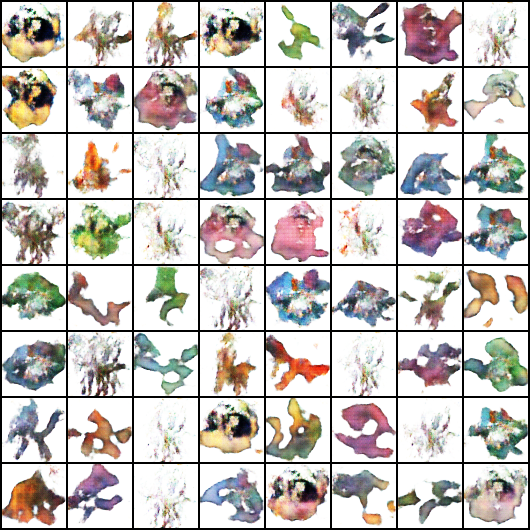

In [26]:
from IPython.display import Image
Image('./generated/generated-images-1000.png')


In [27]:
vid_fname = 'Pokemon_gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

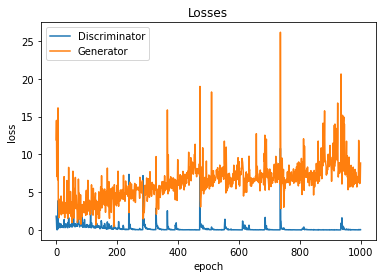

In [28]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

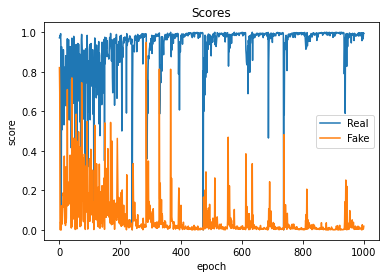

In [29]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');